In [1]:
!pip install geopandas
!pip install earthpy
!pip install mlxtend

     |████████████████████████████████| 972kB 5.9MB/s 
     |████████████████████████████████| 6.5MB 29.2MB/s 
     |████████████████████████████████| 14.8MB 255kB/s 
     |████████████████████████████████| 1.4MB 4.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 18.3MB 245kB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp36-none-any.whl size=1365088 sha256=c7b54fbdabf469e1d8190153b01d97f61067d30d06b4da14e41822582cc2c147
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


In [2]:
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
from tqdm.notebook import tqdm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.evaluate import PredefinedHoldoutSplit
import json
import copy
import urllib.request
# pd.set_option("display.max_rows", None, "display.max_columns", None)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7f6521eb6668>)

## Process Oxford data

In [4]:
oxford_data = pd.read_csv(DATA_FILE,
                          parse_dates=['Date'],
                          encoding="ISO-8859-1",
                          dtype={"RegionName": str,
                                 "RegionCode": str},
                          error_bad_lines=False)
oxford_data.head()

CountryName CountryCode  ... EconomicSupportIndex EconomicSupportIndexForDisplay
0       Aruba         ABW  ...                  0.0                            0.0
1       Aruba         ABW  ...                  0.0                            0.0
2       Aruba         ABW  ...                  0.0                            0.0
3       Aruba         ABW  ...                  0.0                            0.0
4       Aruba         ABW  ...                  0.0                            0.0

[5 rows x 49 columns]

In [5]:
cols = oxford_data.columns
for col in cols:
    if 'Index' in col or 'Flag' in col or 'Wildcard' in col:
        oxford_data.drop(columns=col, inplace=True)
oxford_data['ConfirmedCases'].fillna(0, inplace=True)
oxford_data['ConfirmedDeaths'].fillna(0, inplace=True)
oxford_data['C1_School closing'].fillna(0, inplace=True)
oxford_data['C2_Workplace closing'].fillna(0, inplace=True)
oxford_data['C3_Cancel public events'].fillna(0, inplace=True)
oxford_data['C4_Restrictions on gatherings'].fillna(0, inplace=True)
oxford_data['C5_Close public transport'].fillna(0, inplace=True)
oxford_data['C6_Stay at home requirements'].fillna(0, inplace=True)
oxford_data['C7_Restrictions on internal movement'].fillna(0, inplace=True)
oxford_data['C8_International travel controls'].fillna(0, inplace=True)
oxford_data['E1_Income support'].fillna(0, inplace=True)
oxford_data['E2_Debt/contract relief'].fillna(0, inplace=True)
oxford_data['E3_Fiscal measures'].fillna(0, inplace=True)
oxford_data['E4_International support'].fillna(0, inplace=True)
oxford_data['H1_Public information campaigns'].fillna(0, inplace=True)
oxford_data['H2_Testing policy'].fillna(0, inplace=True)
oxford_data['H3_Contact tracing'].fillna(0, inplace=True)
oxford_data['H4_Emergency investment in healthcare'].fillna(0, inplace=True)
oxford_data['H5_Investment in vaccines'].fillna(0, inplace=True)
oxford_data['H6_Facial Coverings'].fillna(0, inplace=True)
oxford_data['H7_Vaccination policy'].fillna(0, inplace=True)

oxford_data['GeoID'] = oxford_data['CountryName'] + '__' + oxford_data['RegionName'].astype(str)
oxford_data['NewCases'] = oxford_data.groupby('GeoID').ConfirmedCases.diff().fillna(0)
oxford_data['NewDeaths'] = oxford_data.groupby('GeoID').ConfirmedDeaths.diff().fillna(0)
oxford_data.drop(columns=['Jurisdiction', 'RegionCode'], inplace=True)
oxford_data.drop(columns=['CountryCode'], inplace=True)

# move column to be earlier
geoid = oxford_data['GeoID']
oxford_data.drop(labels=['GeoID'], axis = 1, inplace = True)
oxford_data.insert(3, 'GeoID', geoid)

oxford_data.head()

CountryName RegionName       Date  ... ConfirmedDeaths  NewCases  NewDeaths
0       Aruba        NaN 2020-01-01  ...             0.0       0.0        0.0
1       Aruba        NaN 2020-01-02  ...             0.0       0.0        0.0
2       Aruba        NaN 2020-01-03  ...             0.0       0.0        0.0
3       Aruba        NaN 2020-01-04  ...             0.0       0.0        0.0
4       Aruba        NaN 2020-01-05  ...             0.0       0.0        0.0

[5 rows x 27 columns]

In [6]:
oxford_data.drop(columns=['ConfirmedCases', 'ConfirmedDeaths', 'NewDeaths'], inplace=True)
# Remove non USA regions for now
oxford_data = oxford_data[(oxford_data['CountryName'] == 'United States') & (oxford_data['RegionName'].notnull())]
print(oxford_data['RegionName'].unique())
oxford_data.head()

['Alaska' 'Alabama' 'Arkansas' 'Arizona' 'California' 'Colorado'
 'Connecticut' 'Washington DC' 'Delaware' 'Florida' 'Georgia' 'Hawaii'
 'Iowa' 'Idaho' 'Illinois' 'Indiana' 'Kansas' 'Kentucky' 'Louisiana'
 'Massachusetts' 'Maryland' 'Maine' 'Michigan' 'Minnesota' 'Missouri'
 'Mississippi' 'Montana' 'North Carolina' 'North Dakota' 'Nebraska'
 'New Hampshire' 'New Jersey' 'New Mexico' 'Nevada' 'New York' 'Ohio'
 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Virginia' 'Virgin Islands'
 'Vermont' 'Washington' 'Wisconsin' 'West Virginia' 'Wyoming']


CountryName RegionName  ... H7_Vaccination policy NewCases
70584  United States     Alaska  ...                   0.0      0.0
70585  United States     Alaska  ...                   0.0      0.0
70586  United States     Alaska  ...                   0.0      0.0
70587  United States     Alaska  ...                   0.0      0.0
70588  United States     Alaska  ...                   0.0      0.0

[5 rows x 24 columns]

In [7]:
# Remove current day and previous day because data may be incomplete
oxford_data = oxford_data.groupby("GeoID", as_index=False).apply(lambda x: x.iloc[:-2])
oxford_data = oxford_data.sort_values(by=['Date'])
# Move columns around
date_col = oxford_data.pop('Date')
oxford_data.insert(0, 'Date', date_col)
cases_col = oxford_data.pop('NewCases')
oxford_data.insert(4, 'NewCases', cases_col)

oxford_data = oxford_data.reset_index(drop=True)
oxford_data

# california_df = oxford_data[oxford_data['RegionName'] == 'California']
# plt.bar(california_df['Date'], california_df['NewCases'])

# texas_df = oxford_data[oxford_data['RegionName'] == 'Texas']
# plt.bar(texas_df['Date'], texas_df['NewCases'])

Date    CountryName  ... H6_Facial Coverings H7_Vaccination policy
0     2020-01-01  United States  ...                 0.0                   0.0
1     2020-01-01  United States  ...                 0.0                   0.0
2     2020-01-01  United States  ...                 0.0                   0.0
3     2020-01-01  United States  ...                 0.0                   0.0
4     2020-01-01  United States  ...                 0.0                   0.0
...          ...            ...  ...                 ...                   ...
17883 2020-12-09  United States  ...                 0.0                   0.0
17884 2020-12-09  United States  ...                 0.0                   0.0
17885 2020-12-09  United States  ...                 0.0                   0.0
17886 2020-12-09  United States  ...                 0.0                   0.0
17887 2020-12-09  United States  ...                 0.0                   0.0

[17888 rows x 24 columns]

# Used Features

In [8]:
print('Concatenate anything else you use that is not in the oxford data. Make sure its the same order')
feature_names = list(oxford_data.columns[4:].values)
feature_names

Concatenate anything else you use that is not in the oxford data. Make sure its the same order


['NewCases',
 'C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'H6_Facial Coverings',
 'H7_Vaccination policy']

# Add columns for previous n days new cases and next day new cases

In [17]:
def generate_data(data, time_window=1):
    data2 = data.copy()
    
    # add columns for previous days cases and next day cases
    for i in range(1, time_window):
        col_name = 'T-{n}'.format(n=i)
        data2[col_name] = 0
    data2['T+1'] = 0
    
    for index, row in data2.iterrows():
        for i in range(1, time_window):
            try:
                data2.at[index, 'T-{n}'.format(n=i)] = data2.loc[(data2['GeoID'] == row.GeoID) & (data2['Date'] == row.Date - datetime.timedelta(days=i))].NewCases.values[0]
            except IndexError:
                data2.at[index,'T-{n}'.format(n=i)] = 0
        try:
            data2.at[index, 'T+1'] = data2.loc[(data2['GeoID'] == row.GeoID) & (data2['Date'] == row.Date + datetime.timedelta(days=1))].NewCases.values[0]
        except IndexError:
            data2.at[index,'T+1'] = None
            
    data2 = data2.dropna()
    return data2

In [18]:
data = generate_data(oxford_data, 3)
data


Date    CountryName     RegionName  ...    T-1    T-2      T+1
0     2020-01-01  United States        Alabama  ...      0      0      0.0
1     2020-01-01  United States     Washington  ...      0      0      0.0
2     2020-01-01  United States         Nevada  ...      0      0      0.0
3     2020-01-01  United States       Nebraska  ...      0      0      0.0
4     2020-01-01  United States        Montana  ...      0      0      0.0
...          ...            ...            ...  ...    ...    ...      ...
17831 2020-12-08  United States       Delaware  ...    799    816    929.0
17832 2020-12-08  United States     California  ...  24155  28732  33591.0
17833 2020-12-08  United States  Washington DC  ...    183    264    265.0
17834 2020-12-08  United States   Pennsylvania  ...   9107   7465   8613.0
17835 2020-12-08  United States           Utah  ...   2231   2563   2574.0

[17836 rows x 27 columns]

# Model Training

### Data Transformation

In [ ]:
def transform_data(data):
    pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
#     pipe = make_pipeline(StandardScaler())
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data.reshape(-1,), pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1)).reshape(-1,)
    return pipe.inverse_transform(data)

### Time validation

In [ ]:
data.iloc[:, 4:].to_numpy()

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [  270.,     0.,     0., ...,   183.,   264.,   265.],
       [10104.,     0.,     0., ...,  9107.,  7465.,  8613.],
       [ 2333.,     0.,     0., ...,  2231.,  2563.,  2574.]])

In [ ]:
def n_month_window_split(data, train_n, transform = True):
    data2 = data.copy()
    data2 = data2.drop(['CountryName', 'RegionName'], axis=1)

    X_train_arr = []
    X_test_arr = []
    y_train_arr = []
    y_test_arr = []
    ptX_arr = []
    pty_arr = []
    
    initial_date = data2['Date'].min()
    last_date = data2['Date'].max()
    test_date = last_date-datetime.timedelta(30)
    train_date = last_date-datetime.timedelta((train_n+1)*30)
    while train_date >= initial_date:
        data_test = data2.loc[(data2['Date']>=test_date) & (data2['Date']<=last_date)]
        print("===========")
        print(train_date)
        X_test = data_test.iloc[:, :-1].to_numpy()
        y_test = data_test.iloc[:, -1].to_numpy()
        
        data_train = data2.loc[(data2['Date']>=first_date) & (data2['Date']<test_date)]
        X_train = temp.iloc[:, :-1].to_numpy()
        y_train = temp.iloc[:, -1].to_numpy()
        
        X_train_arr.append(X_train)
        X_test_arr.append(X_test)
        y_train_arr.append(y_train)
        y_test_arr.append(y_test)
        
        last_date = last_date-datetime.timedelta(31)
        test_date = last_date-datetime.timedelta(30)
        train_date = last_date-datetime.timedelta((train_n+1)*30)
        
    
#     for i in range(int(data2[0,0]), int(data2[-1,0]-n+1)):
#         train_start_index = np.where(data2[:,0]==i)[0][0]
#         train_end_index = np.where(data2[:,0]==i+n)[0][0]
#         test_start_index = train_end_index
#         test_end_index = np.where(data2[:,0]==i+n)[0][-1]+1
#         X_train = data2[train_start_index:train_end_index, 1:-1]
#         X_test = data2[test_start_index:test_end_index, 1:-1]
#         y_train = data2[train_start_index:train_end_index, -1]
#         y_test = data2[test_start_index:test_end_index, -1]

        

#         # Feature transformation
#         ## Transformation should be done on the training set and applied on testing set
#         if transform:
#             X_train, pt_X = transform_data2(X_train)
#             X_test = apply_transform(pt_X, X_test)
#             y_train, pt_y = transform_data2(y_train)
#             y_test = apply_transform(pt_y, y_test)
#             ptX_arr.append(pt_X)
#             pty_arr.append(pt_y)
        
#         X_train_arr.append(X_train)
#         X_test_arr.append(X_test)
#         y_train_arr.append(y_train)
#         y_test_arr.append(y_test)
        
    return (X_train_arr, X_test_arr, y_train_arr, y_test_arr, ptX_arr, pty_arr)

In [ ]:
a,b,c,d,e,f = n_month_window_split(data, 4)
print(a.shape, b.shape, c.shape, d.shape)

KeyError: 'Date'

### Feature selection

In [ ]:
def f_selection(model, kfeatures, X_train, X_test, y_train, y_test, floating=False):
    fs_X = np.vstack((X_train,X_test))
    fs_y = np.hstack((y_train, y_test))
    fs_cv_in = np.array(list(range(X_train.shape[0]-1,fs_X.shape[0])))
    piter = PredefinedHoldoutSplit(fs_cv_in)

    sfs1 = sfs(model,
            k_features=kfeatures,
            forward=True,
            floating=floating,
            verbose=0,
            scoring='r2',
            cv=piter)

    # Perform SFFS
    sfs1 = sfs1.fit(fs_X, fs_y)
    return sfs1.subsets_

In [ ]:
def get_fs_data(data, feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
#     optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    optimal_index = np.array(list(optimal_feat['feature_idx']))
    names = np.array(feature_names)[optimal_index]
    print(names)
    print(optimal_r2)
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    
    temp = np.append(optimal_index+1, data.shape[1]-1)
    data2 = copy.deepcopy(data[:, np.insert(temp, 0, 0, axis=0)]) # Insert month and target columns
    return (data2, names)

In [ ]:
print(la_filtered.head())

            region                                           geometry  plot_col
0            Acton  POLYGON ((-118.20262 34.53899, -118.18947 34.5...         0
1  Adams-Normandie  POLYGON ((-118.30901 34.03741, -118.30041 34.0...         0
2     Agoura Hills  POLYGON ((-118.76193 34.16820, -118.72632 34.1...         0
3       Agua Dulce  POLYGON ((-118.25468 34.55830, -118.25551 34.5...         0
4         Alhambra  POLYGON ((-118.12175 34.10504, -118.11687 34.1...         0


### Train model

In [ ]:
def generate_map(predicted, actual, region_names, month='October'):
  map_data_dict = {'region': region_names, 'Predicted': predicted, 'Actual': actual}
  map_data = pd.DataFrame(map_data_dict)
  map_data['Actual'] = map_data['Actual'].astype(int)
  map_data['Error'] = (map_data['Predicted'] - map_data['Actual']).astype(int)
  map_data['% Error'] = 100.0 * (map_data['Actual'] - map_data['Predicted']).abs().astype(float) / map_data['Actual']
  df = la_filtered.merge(map_data, on='region', how='inner')
  print(df[df['% Error'] > 50][['region','Predicted','Actual','Error', '% Error']].sort_values('Error', ascending=False))

  # plot used regions
  used = map_data[la_filtered['region'].isin(region_names)]
  colors = ['green' if region in region_names else 'blue' for region in la_filtered['region']]
  la_filtered.plot(color=colors, figsize=(8,6))

  # plot predicted cases
  f, ax = plt.subplots(1, figsize=(8,6))
  df.plot(column='Predicted', ax=ax, vmin = 0, vmax = max(df['Predicted'].max(), df['Actual'].max()), legend=True)
  f.suptitle('Predicted COVID-19 cases distribution for {m}'.format(m=month))

  # plot actual cases
  f, ax = plt.subplots(1, figsize=(8,6))
  df.plot(column='Actual', ax=ax, vmin = 0, vmax = max(df['Predicted'].max(), df['Actual'].max()), legend=True)
  f.suptitle('Actual COVID-19 cases distribution for {m}'.format(m=month))

  # plot error
  f, ax = plt.subplots(1, figsize=(8,6))
  df.plot(column='Error', ax=ax, legend=True)
  f.suptitle('Error (predicted - actual) in COVID-19 cases distribution for {m}'.format(m=month))

  plt.show()

def train_model(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, pty_arr, n, region_names):
    inverse_y_test_arr = []
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        inverse_y_test_arr.append(inverse_transform(pty_arr[i], y_test_arr[i]))
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(inverse_transform(pty_arr[i], model.predict(X_test_arr[i])))
        mse_arr.append(mean_squared_error(y_pred_arr[i], inverse_y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], inverse_y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], inverse_y_test_arr[i]))
        avg_arr.append(np.average(inverse_y_test_arr[i]))
    print('MSE: {a}; avg = {mseA} \nr2: {b}; avg = {r2A}\nMAE: {c}; avg = {maeA}\navg: {d}; avg = {avgA}'.format(
        a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr, 
        mseA=np.array(mse_arr).mean(),
        r2A=np.array(r2_arr).mean(),
        maeA=np.array(mae_arr).mean(),
        avgA=np.array(avg_arr).mean()
    ))
    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(inverse_y_test_arr[0], y_pred_arr[0])
        ax.plot([inverse_y_test_arr[0].min(), inverse_y_test_arr[0].max()], [inverse_y_test_arr[0].min(), inverse_y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        generate_map(y_pred_arr[0], inverse_y_test_arr[0], region_names, calendar.month_name[i+5+n])
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(inverse_y_test_arr[i], y_pred_arr[i])
        axs[i].plot([inverse_y_test_arr[i].min(), inverse_y_test_arr[i].max()], [inverse_y_test_arr[i].min(), inverse_y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
        generate_map(y_pred_arr[i], inverse_y_test_arr[i], region_names, calendar.month_name[i+5+n])
    fig.suptitle(graph_title, fontsize=16)
    plt.show()


In [ ]:
def train_model_no_transform(X_train_arr, X_test_arr, y_train_arr, y_test_arr, model, graph_title, n):
    y_pred_arr = []
    mse_arr = []
    r2_arr = []
    mae_arr = []
    avg_arr = []

    for i in range(len(X_train_arr)):
        model.fit(X_train_arr[i], y_train_arr[i])
        y_pred_arr.append(model.predict(X_test_arr[i]))
        mse_arr.append(mean_squared_error(y_pred_arr[i], y_test_arr[i]))
        r2_arr.append(r2_score(y_pred_arr[i], y_test_arr[i]))
        mae_arr.append(mean_absolute_error(y_pred_arr[i], y_test_arr[i]))
        avg_arr.append(np.average(y_test_arr[i]))
    print('MSE: {a}; avg = {mseA} \nr2: {b}; avg = {r2A}\nMAE: {c}; avg = {maeA}\navg: {d}; avg = {avgA}'.format(
        a=mse_arr, b=r2_arr, c=mae_arr, d=avg_arr, 
        mseA=np.array(mse_arr).mean(),
        r2A=np.array(r2_arr).mean(),
        maeA=np.array(mae_arr).mean(),
        avgA=np.array(avg_arr).mean()
    ))

    if len(avg_arr)==1:
        # Graph
        fig, ax = plt.subplots(figsize=[8,6])
        ax.scatter(y_test_arr[0], y_pred_arr[0])
        ax.plot([y_test_arr[0].min(), y_test_arr[0].max()], [y_test_arr[0].min(), y_test_arr[0].max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[i+5+n]))
        plt.show()
        return
    fig, axs = plt.subplots(len(avg_arr), figsize=[8,12], constrained_layout=True)
    for i in range(len(avg_arr)):
        axs[i].scatter(y_test_arr[i], y_pred_arr[i])
        axs[i].plot([y_test_arr[i].min(), y_test_arr[i].max()], [y_test_arr[i].min(), y_test_arr[i].max()], 'k--', lw=4)
        axs[i].set_xlabel('Measured')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title('Prediction for {m}'.format(m=calendar.month_name[i+5+n]))
    fig.suptitle(graph_title, fontsize=16)
    plt.show()

In [ ]:
def train_model_single(X_train, X_test, y_train, y_test, model, graph_title, month, pty, region_names):
    inverse_y_test = inverse_transform(pty, y_test)
    model.fit(X_train, y_train)
    y_pred = inverse_transform(pty, model.predict(X_test))
    mse = mean_squared_error(y_pred, inverse_y_test)
    r2 = r2_score(y_pred, inverse_y_test)
    mae = mean_absolute_error(y_pred, inverse_y_test)
    avg =  np.average(inverse_y_test)
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=avg))

    # Graph
    fig, ax = plt.subplots(figsize=[8,4])
    ax.scatter(inverse_y_test, y_pred)
    ax.plot([inverse_y_test.min(), inverse_y_test.max()], [inverse_y_test.min(), inverse_y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title('{graph_title}\nPrediction for month {m}'.format(graph_title=graph_title, m=calendar.month_name[month]))
    plt.show()
    generate_map(y_pred, inverse_y_test, region_names, month=calendar.month_name[month])


### Local search


In [ ]:
def search_model(X_train, X_test, y_train, y_test, model, graph_title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    mae = mean_absolute_error(y_pred, y_test)
    error = {
        'mse': mse,
        'r2': r2,
        'mae': mae
    }
    print('MSE: {a} \nr2: {b} \nMAE: {c} \navg: {d}'.format(a=mse, b=r2, c=mae, d=np.average(y_test)))
    
    # Graph
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(graph_title)
    plt.show()
    print(model.best_estimator_)

### Feature Importance

In [ ]:
# Feature importance graphs for SVR
def f_importances(model, names, model_name):
    if model_name == 'linear':
        ## Graph absolute value of feature importance
        w = pd.Series(abs(model.coef_))
        w,n = zip(*sorted(zip(w,names), reverse=True))
        plt.barh(n[:10][::-1], w[:10][::-1])
        # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
        # plt.yticks(range(len(names)), names)
        plt.show()
        
        w = pd.Series(model.coef_)
        df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
        return df[['Feature Name','Weight']]
    if model_name == 'SVR':
        ## Graph absolute value of feature importance
        w = pd.Series(abs(model.coef_[0]))
        w,n = zip(*sorted(zip(w,names), reverse=True))
        plt.barh(n[:10][::-1], w[:10][::-1])
        # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
        # plt.yticks(range(len(names)), names)
        plt.show()
        
        w = pd.Series(model.coef_[0])
        df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
        return df[['Feature Name','Weight']]
    
    ## Graph absolute value of feature importance
    w = pd.Series(abs(model.feature_importances_))
    w,n = zip(*sorted(zip(w,names), reverse=True))
    plt.barh(n[:10][::-1], w[:10][::-1])
    # plt.barh(range(len(names)), pd.Series(abs(imp[0])).nlargest(10), align='center')
    # plt.yticks(range(len(names)), names)
    plt.show()

    w = pd.Series(abs(model.feature_importances_))
    df = pd.DataFrame(sorted(zip(w,names), reverse=True), columns=['Weight','Feature Name'])
    return df[['Feature Name','Weight']]

# Linear Regression

### Cases Only

In [ ]:
lin_model = LinearRegression()

Carson
Culver City
Stevenson Ranch
South El Monte
Covina
Hawthorne
South Whittier
El Segundo
Athens
Duarte
Florence
Willowbrook
Valinda
Playa del Rey
Rolling Hills
Pasadena
Acton
Avalon
Avocado Heights
Lake Los Angeles
Angeles Crest
173
MSE: [9122.897980305868]; avg = 9122.897980305868 
r2: [0.4322853404116255]; avg = 0.4322853404116255
MAE: [76.29456691058596]; avg = 76.29456691058596
avg: [180.364161849711]; avg = 180.364161849711


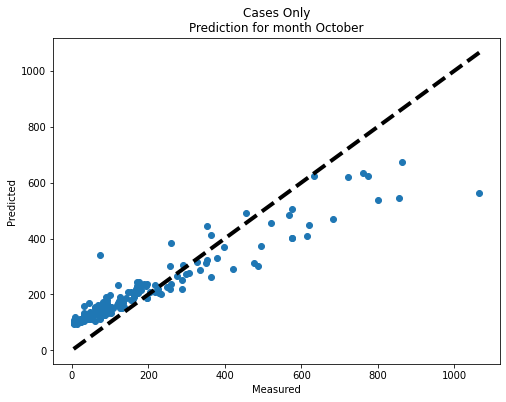

In [ ]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases Only", 5)

### Add Normalization

Carson
Culver City
Stevenson Ranch
South El Monte
Covina
Hawthorne
South Whittier
El Segundo
Athens
Duarte
Florence
Willowbrook
Valinda
Playa del Rey
Rolling Hills
Pasadena
Acton
Avalon
Avocado Heights
Lake Los Angeles
Angeles Crest
173
MSE: [4234.393856887785]; avg = 4234.393856887785 
r2: [0.8672175665828208]; avg = 0.8672175665828208
MAE: [39.6283166161174]; avg = 39.6283166161174
avg: [180.364161849711]; avg = 180.364161849711


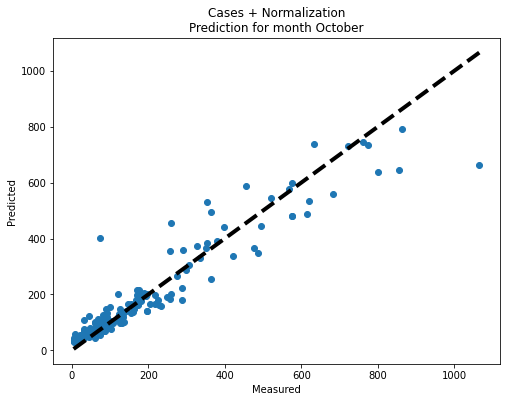

                    region   Predicted  Actual  Error     % Error
149        University Park  403.788017      73    330  453.134269
68         Huntington Park  457.000342     260    197   75.769362
11            Baldwin Park  531.363474     354    177   50.102676
26                 Castaic  200.818841     120     80   67.349034
6        Arlington Heights  122.016362      45     77  171.147472
7                  Artesia  108.676456      32     76  239.613925
50                 Gardena  156.126952      99     57   57.703992
53                Glendora  147.814246      90     57   64.238051
114            Playa Vista   59.677753       8     51  645.971916
62        Hawaiian Gardens   78.015901      31     47  151.664197
17           Beverly Hills  112.776814      69     43   63.444657
3                 Altadena  125.100927      83     42   50.724008
126            San Gabriel  101.508764      61     40   66.407810
127             San Marino   45.436333       7     38  549.090467
75    La C

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


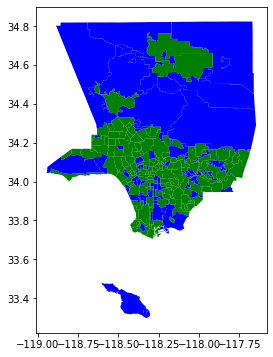

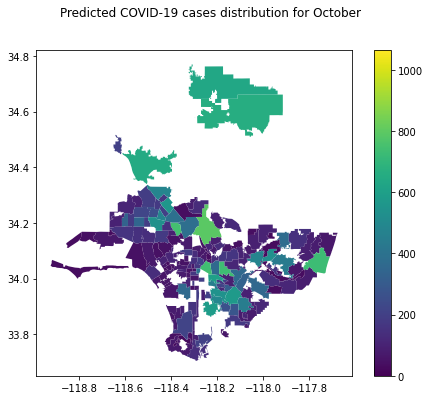

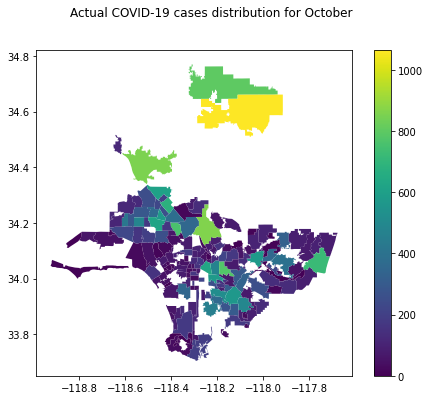

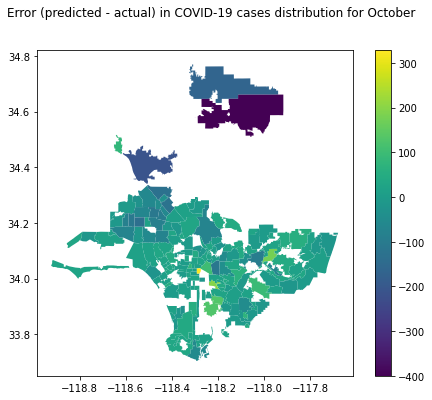

In [ ]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization", nc5m_pty_arr, 5, used_regions)

### Add Migration

Pasadena
90
MSE: [4360.096726679174]; avg = 4360.096726679174 
r2: [0.8473712257434733]; avg = 0.8473712257434733
MAE: [40.85486365693789]; avg = 40.85486365693789
avg: [193.5888888888889]; avg = 193.5888888888889


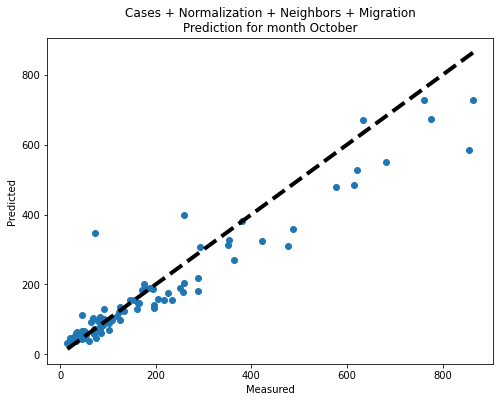

                 region   Predicted  Actual  Error     % Error
74      University Park  347.591172      73    274  376.152290
33      Huntington Park  398.250816     260    138   53.173391
3     Arlington Heights  112.183338      45     67  149.296308
57  Rancho Palos Verdes   63.745768      35     28   82.130765
28         Hancock Park   60.305221      33     27   82.743095
71          Toluca Lake   47.504093      21     26  126.209967
80       Vermont Square   53.128884      31     22   71.383498
8           Beverlywood   50.203767      29     21   73.116439
6         Beverly Crest   44.290377      26     18   70.347605
22         Elysian Park   31.547219      15     16  110.314793
62         Shadow Hills   35.370619      20     15   76.853094


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


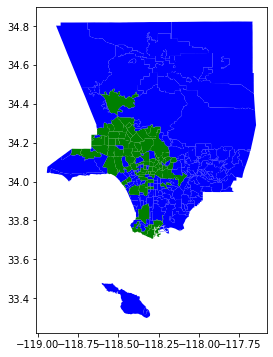

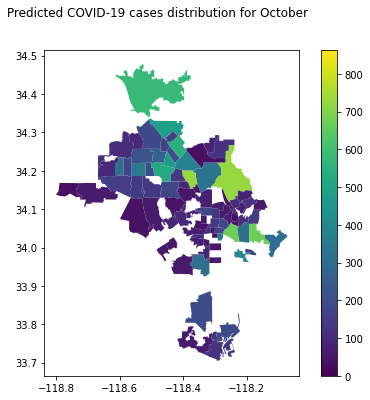

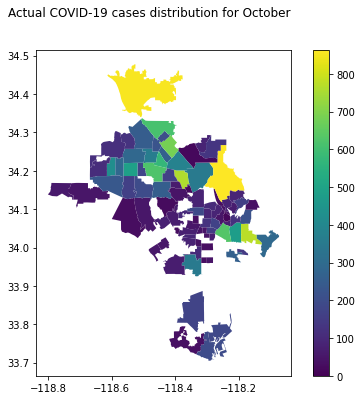

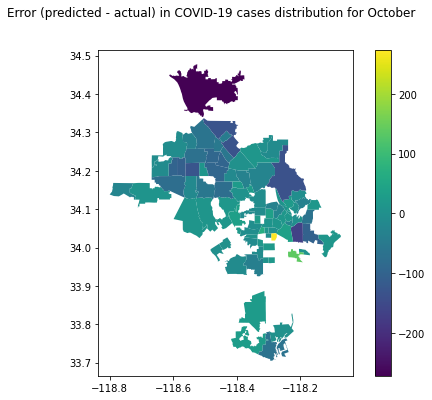

In [ ]:
month_data, used_regions = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5, used_regions)

### Add Census

Pasadena
90
MSE: [10382.625285319476]; avg = 10382.625285319476 
r2: [0.7866323285015117]; avg = 0.7866323285015117
MAE: [59.02505637834101]; avg = 59.02505637834101
avg: [193.5888888888889]; avg = 193.5888888888889


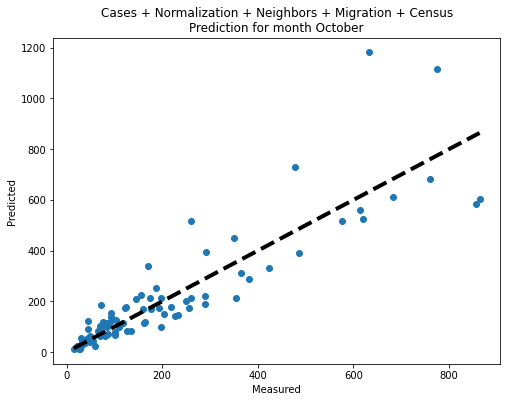

             region    Predicted  Actual  Error     % Error
16         Downtown  1181.231694     633    548   86.608482
33  Huntington Park   517.508200     260    257   99.041615
9     Boyle Heights   729.302829     477    252   52.893675
85         Westlake   338.017270     171    167   97.670918
74  University Park   186.676557      73    113  155.721311
79   Vermont Knolls   120.954649      45     75  168.788110
18   East Hollywood   154.007255      92     62   67.399190
81       West Adams   140.241606      92     48   52.436528
29  Harvard Heights    91.459329      45     46  103.242953
44         Mid-City   117.305211      77     40   52.344430
80   Vermont Square    54.087698      31     23   74.476444
1      Agoura Hills    22.471415      60    -37   62.547641


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


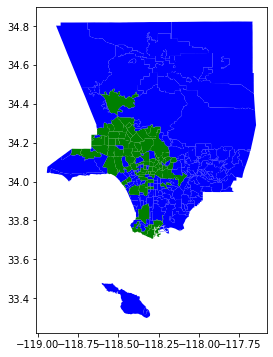

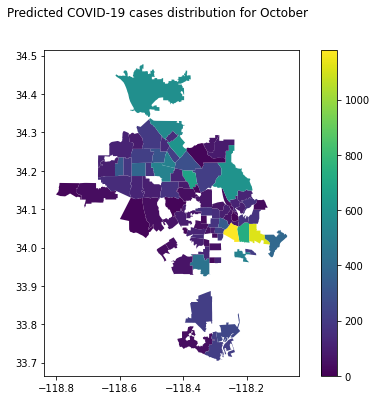

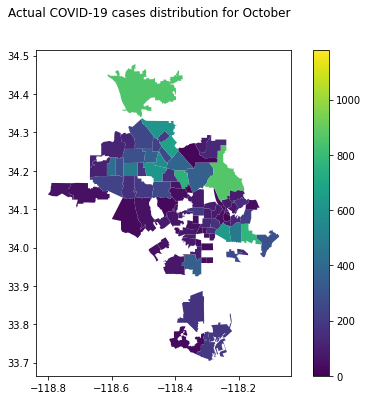

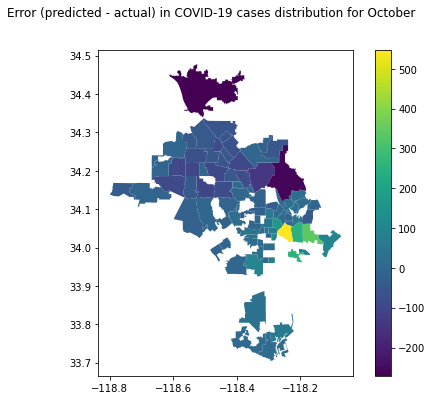

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5, used_regions)

## 5-month window

### Feature Selection

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data, 5)
# lin_feat_subsets5 = f_selection(lin_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_X_test_arr[0],wc5m_y_train_arr[0],wc5m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets5.npy', lin_feat_subsets5, allow_pickle=True)

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Food Services workers' 'Total Population: 5 to 9 Years'
 'Total Population: 15 to 17 Years' 'Total Population: 25 to 34 Years'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration'
 'Employed Civilian Population 16 Years and Over1: Unpaid Family Workers'
 'Households6: with Supplemental Security Income (Ssi)'
 'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level'
 'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income At or Above Poverty Level'
 'Asian Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level'
 'Native Hawaiian and Other Pacific Islander Alone &

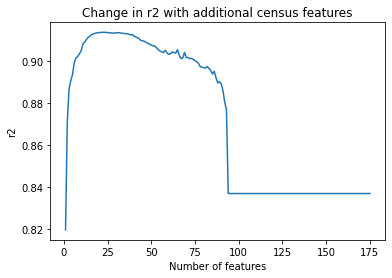

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets5.npy
lin_feat_subsets5 = np.load('../data/feat_selection/lin_feat_subsets5.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets5)

In [ ]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

MSE: [4360.096726679174]; avg = 4360.096726679174 
r2: [0.8473712257434733]; avg = 0.8473712257434733
MAE: [40.85486365693789]; avg = 40.85486365693789
avg: [193.5888888888889]; avg = 193.5888888888889


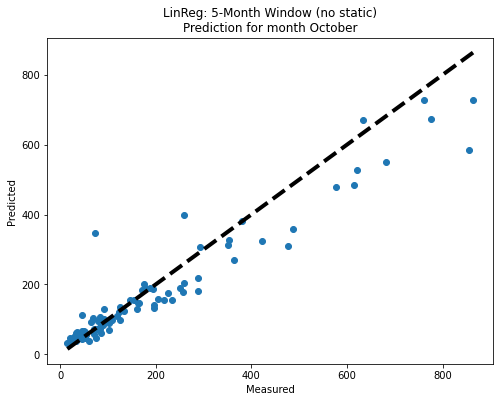

                 region   Predicted  Actual  Error     % Error
74      University Park  347.591172      73    274  376.152290
33      Huntington Park  398.250816     260    138   53.173391
3     Arlington Heights  112.183338      45     67  149.296308
57  Rancho Palos Verdes   63.745768      35     28   82.130765
28         Hancock Park   60.305221      33     27   82.743095
71          Toluca Lake   47.504093      21     26  126.209967
80       Vermont Square   53.128884      31     22   71.383498
8           Beverlywood   50.203767      29     21   73.116439
6         Beverly Crest   44.290377      26     18   70.347605
22         Elysian Park   31.547219      15     16  110.314793
62         Shadow Hills   35.370619      20     15   76.853094


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


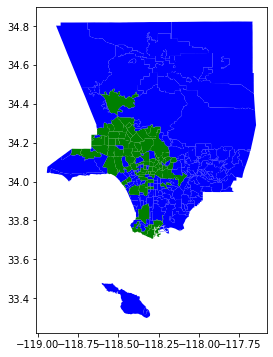

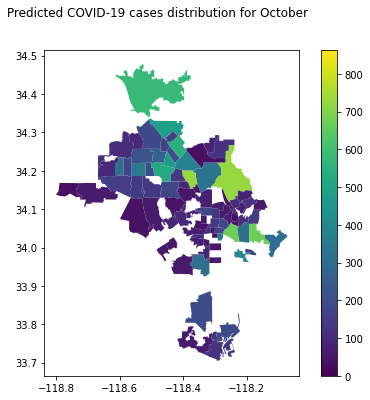

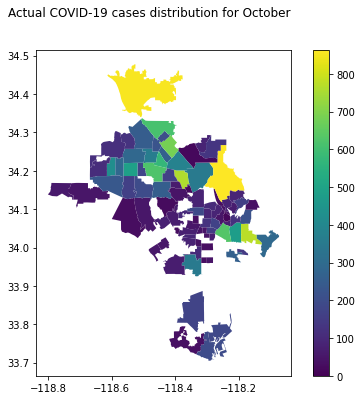

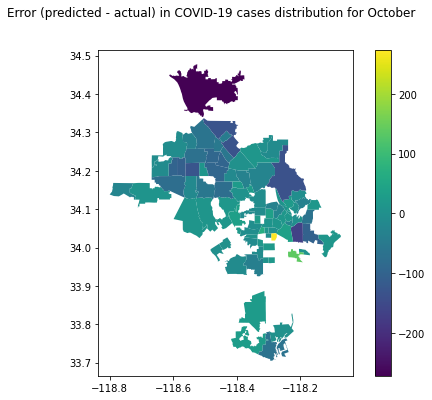

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (no static)", nc5m_pty_arr, 5, used_regions)

MSE: [3541.478624002783]; avg = 3541.478624002783 
r2: [0.8888161956933339]; avg = 0.8888161956933339
MAE: [37.59312869052559]; avg = 37.59312869052559
avg: [193.5888888888889]; avg = 193.5888888888889


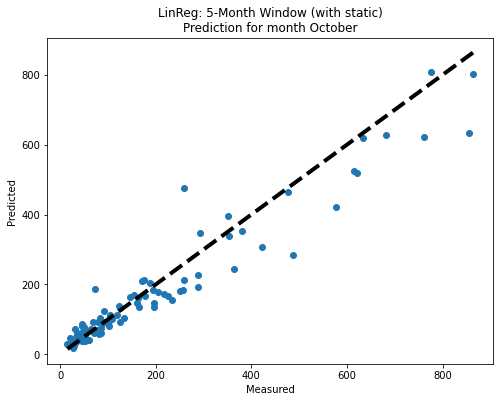

                 region   Predicted  Actual  Error     % Error
33      Huntington Park  474.942669     260    214   82.670257
74      University Park  186.953428      73    113  156.100586
3     Arlington Heights   85.285949      45     40   89.524331
80       Vermont Square   71.917078      31     40  131.990575
79       Vermont Knolls   80.056403      45     35   77.903117
20            Echo Park   77.980935      49     28   59.144764
57  Rancho Palos Verdes   60.172589      35     25   71.921684
71          Toluca Lake   45.250846      21     24  115.480217
22         Elysian Park   28.237717      15     13   88.251447


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


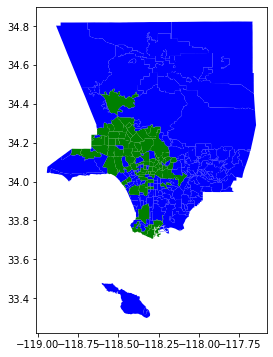

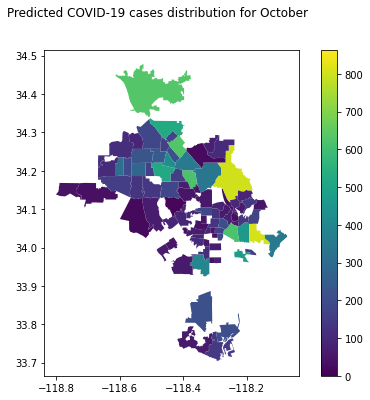

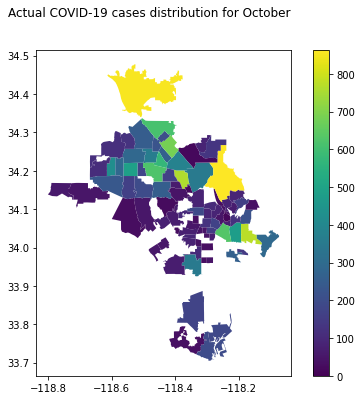

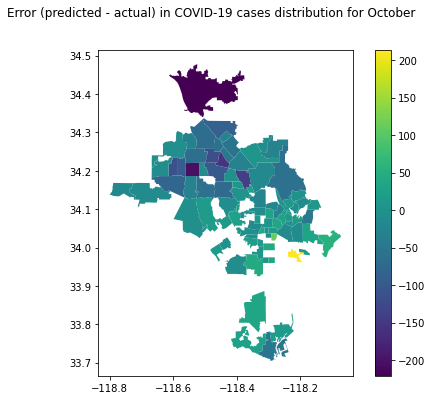

In [ ]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, lin_model, "LinReg: 5-Month Window (with static)", wc5m_pty_arr, 5, used_regions)

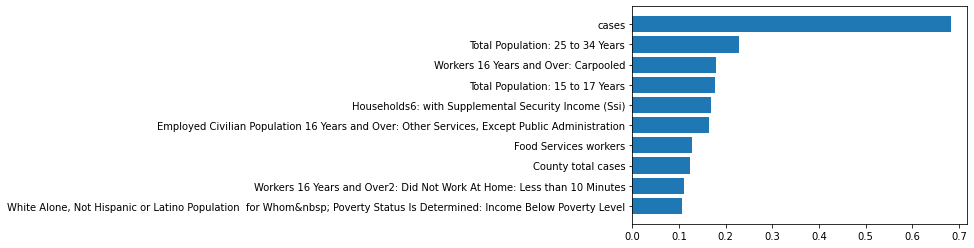

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 4-month window

### Feature Selection 1

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
print(month_data_ns.shape, used_regions)
month_data, used_regions = build_month_data(False, True, True)
print(month_data.shape, used_regions)

Pasadena
90
(540, 6) ['Westchester', 'West Hollywood', 'West Hills', 'West Adams', 'Torrance', 'Tarzana', 'Silver Lake', 'Sherman Oaks', 'San Pedro', 'Northridge', 'Venice', 'Beverly Hills', 'Boyle Heights', 'Downtown', 'Glendale', 'Granada Hills', 'Inglewood', 'Encino', 'North Hollywood', 'Reseda', 'Santa Clarita', 'Woodland Hills', 'Mar Vista', 'Hollywood Hills', 'Baldwin Hills/Crenshaw', 'Brentwood', 'Eagle Rock', 'Hollywood', 'Sylmar', 'Studio City', 'Pacific Palisades', 'Tujunga', 'Westwood', 'Vermont Knolls', 'Van Nuys', 'Valley Glen', 'University Park', 'Calabasas', 'Beverlywood', 'Burbank', 'Echo Park', 'East Los Angeles', 'Hancock Park', 'San Fernando', 'Winnetka', 'Lake Balboa', 'Sun Valley', 'Sunland', 'Westlake', 'Montebello', 'Rancho Palos Verdes', 'East Hollywood', 'Canoga Park', 'Los Feliz', 'Agoura Hills', 'Lincoln Heights', 'Hyde Park', 'Porter Ranch', 'Highland Park', 'Harvard Heights', 'Panorama City', 'Arleta', 'Glassell Park', 'North Hills', 'Pacoima', 'Maywood', '

In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# lin_feat_subsets4_1 = f_selection(lin_model,wc4m_X_train_arr[0].shape[1],wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0], True)


In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets4_1.npy', lin_feat_subsets4_1, allow_pickle=True)

['Incoming migration' 'Outgoing migration' 'Food Services workers'
 'Area Total: Area (Water)' 'Total Population: 18 to 24 Years'
 'Total Population: 75 to 84 Years' 'Total Population: 85 Years and Over'
 'Households: Family Households: Married-Couple Family'
 'Households: Nonfamily Households'
 'Households: Nonfamily Households: Male Householder'
 'Households: Nonfamily Households: Female Householder'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and

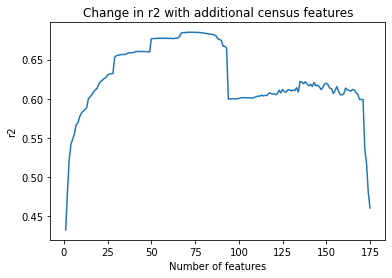

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets4_1.npy
lin_feat_subsets4_1 = np.load('../data/feat_selection/lin_feat_subsets4_1.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets4_1)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 25727.57180054806 
r2: 0.5977181774680311 
MAE: 108.39311013978845 
avg: 141.15555555555557


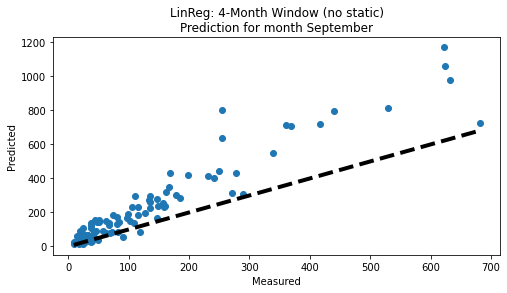

                    region    Predicted  Actual  Error     % Error
19        East Los Angeles  1171.486513     622    549   88.341883
9            Boyle Heights   803.439131     255    548  215.074169
16                Downtown  1060.909448     623    437   70.290441
35               Inglewood   635.552372     255    380  149.236224
53                 Pacoima   797.802356     439    358   81.731744
54           Panorama City   711.978813     361    350   97.224048
50         North Hollywood   978.396925     632    346   54.809640
69                  Sylmar   707.116583     368    339   92.151245
77                Van Nuys   717.894142     416    301   72.570707
61           Santa Clarita   813.400039     529    284   53.761822
87              Wilmington   434.131948     169    265  156.882810
49             North Hills   420.331353     199    221  111.221786
33         Huntington Park   551.029204     339    212   62.545488
47              Montebello   442.734301     249    193   77.80

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


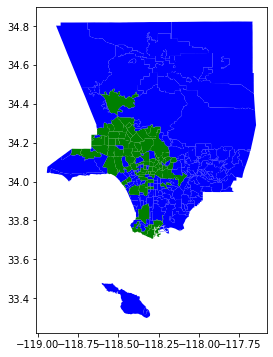

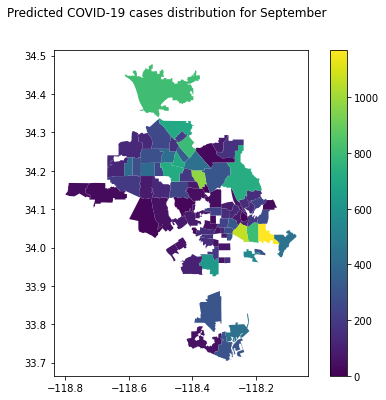

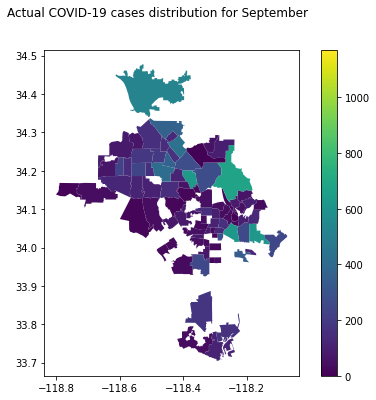

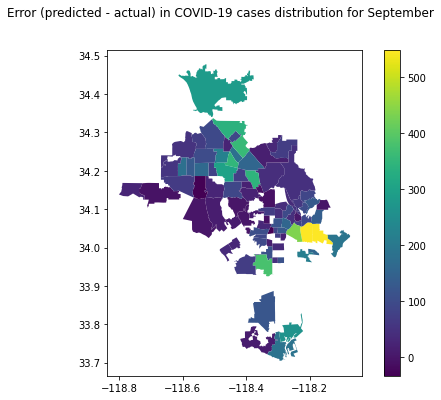

In [ ]:
train_model_single(nc4m_X_train_arr[0], nc4m_X_test_arr[0], nc4m_y_train_arr[0], nc4m_y_test_arr[0], lin_model, "LinReg: 4-Month Window (no static)", 9, nc4m_pty_arr[0], used_regions)

MSE: 24862.76664396264 
r2: 0.6216173977591615 
MAE: 88.26730563371264 
avg: 141.15555555555557


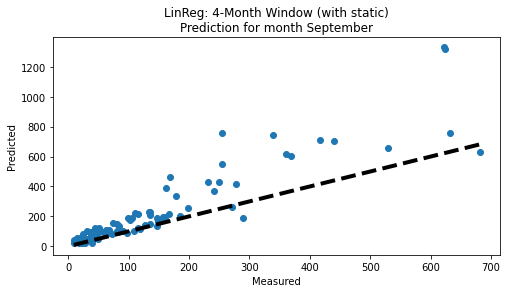

                    region    Predicted  Actual  Error     % Error
19        East Los Angeles  1331.114110     622    709  114.005484
16                Downtown  1322.059927     623    699  112.208656
9            Boyle Heights   758.973736     255    503  197.636759
33         Huntington Park   741.145533     339    402  118.627001
77                Van Nuys   713.217119     416    297   71.446423
35               Inglewood   551.082682     255    296  116.110856
87              Wilmington   462.113835     169    293  173.440139
53                 Pacoima   707.170284     439    268   61.086625
54           Panorama City   619.999725     361    258   71.745076
69                  Sylmar   604.323018     368    236   64.218211
85                Westlake   388.948475     162    226  140.091651
13             Canoga Park   428.102846     232    196   84.527089
47              Montebello   428.193280     249    179   71.965173
72                Torrance   336.208204     179    157   87.82

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


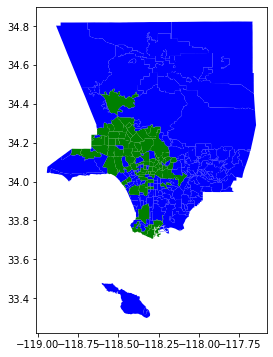

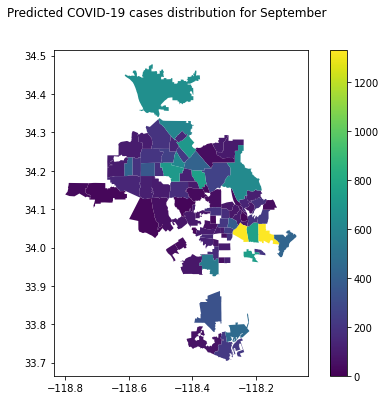

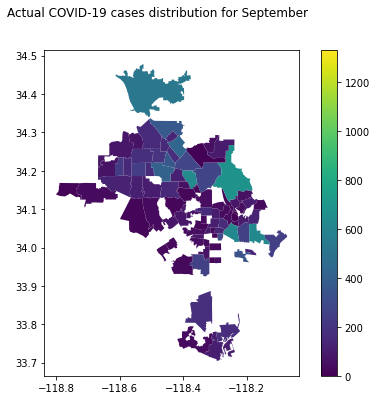

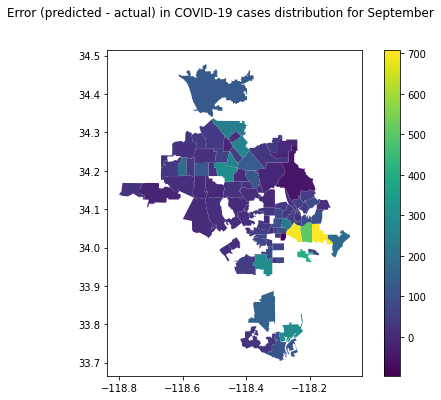

In [ ]:
train_model_single(wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0], lin_model, "LinReg: 4-Month Window (with static)", 9, wc4m_pty_arr[0], used_regions)

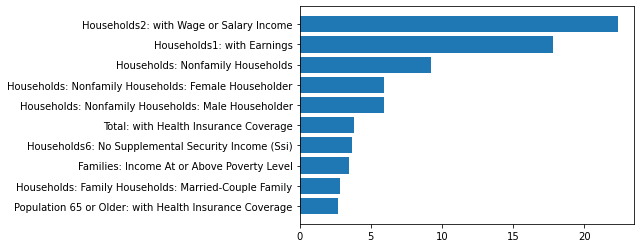

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# lin_feat_subsets4_2 = f_selection(lin_model,wc4m_X_train_arr[1].shape[1],wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1])


In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets4_2.npy', lin_feat_subsets4_2, allow_pickle=True)

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Food Services workers' 'Total Population: 15 to 17 Years'
 'Total Population: 25 to 34 Years'
 'Households: Family Households: Other Family: Male Householder, No Wife Present'
 'Households: Nonfamily Households'
 'Households: Nonfamily Households: Male Householder'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assist

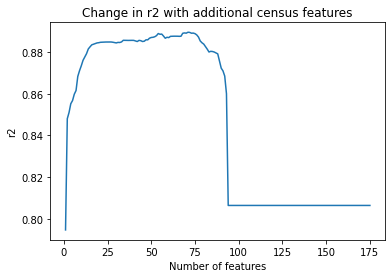

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets4_2.npy
lin_feat_subsets4_2 = np.load('../data/feat_selection/lin_feat_subsets4_2.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets4_2)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 4035.935725710758 
r2: 0.8943106571245893 
MAE: 41.58053585343992 
avg: 193.5888888888889


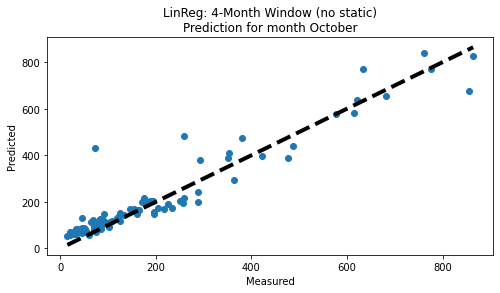

                 region   Predicted  Actual  Error     % Error
74      University Park  429.388103      73    356  488.202881
33      Huntington Park  484.617768     260    224   86.391449
3     Arlington Heights  129.873696      45     84  188.608214
18       East Hollywood  147.445682      92     55   60.267046
7         Beverly Hills  121.541870      69     52   76.147638
57  Rancho Palos Verdes   84.686158      34     50  149.076936
71          Toluca Lake   70.081440      21     49  233.721143
28         Hancock Park   81.479153      33     48  146.906525
76       Valley Village  111.791808      65     46   71.987396
80       Vermont Square   74.725923      31     43  141.051366
8           Beverlywood   71.998706      28     43  157.138235
25        Glassell Park  126.637502      84     42   50.758931
79       Vermont Knolls   86.547078      45     41   92.326840
6         Beverly Crest   66.518329      26     40  155.839727
22         Elysian Park   54.692520      15     39  264

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


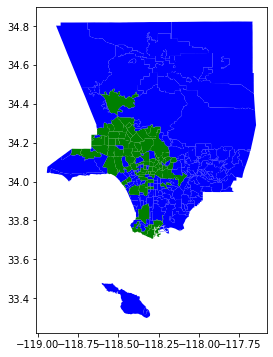

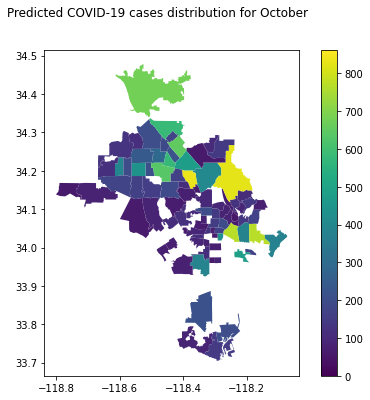

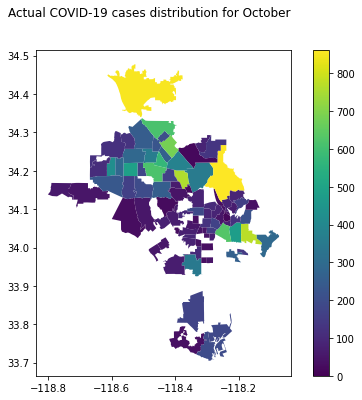

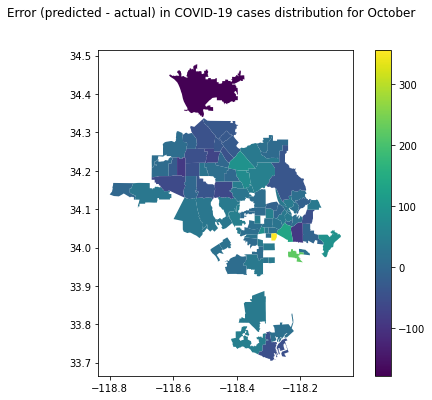

In [ ]:
train_model_single(nc4m_X_train_arr[1], nc4m_X_test_arr[1], nc4m_y_train_arr[1], nc4m_y_test_arr[1], lin_model, "LinReg: 4-Month Window (no static)", 10, nc4m_pty_arr[1], used_regions)

MSE: 5676.955769735852 
r2: 0.8779360069243954 
MAE: 44.22661998338716 
avg: 193.5888888888889


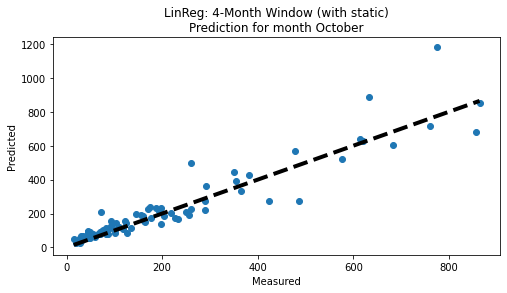

                 region    Predicted  Actual  Error     % Error
19     East Los Angeles  1180.342833     775    405   52.302301
33      Huntington Park   499.180587     260    239   91.992534
74      University Park   208.629756      73    135  185.794187
18       East Hollywood   155.458870      92     63   68.977033
79       Vermont Knolls    97.197791      45     52  115.995092
3     Arlington Heights    91.781897      45     46  103.959772
29      Harvard Heights    89.060605      45     44   97.912455
20            Echo Park    88.504471      49     39   80.621370
22         Elysian Park    51.810787      15     36  245.405247
80       Vermont Square    67.769423      31     36  118.611041
57  Rancho Palos Verdes    65.020147      34     31   91.235726
6         Beverly Crest    48.777770      26     22   87.606808
41    Manchester Square    49.624823      33     16   50.378252
71          Toluca Lake    32.448955      21     11   54.518834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


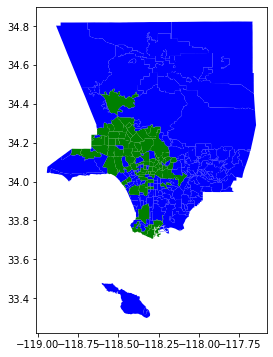

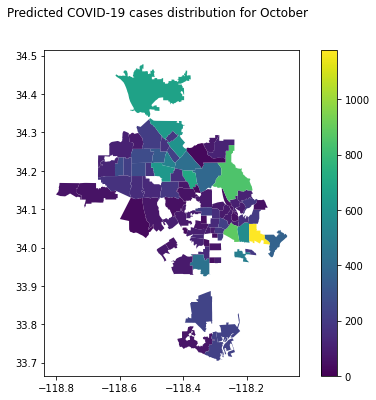

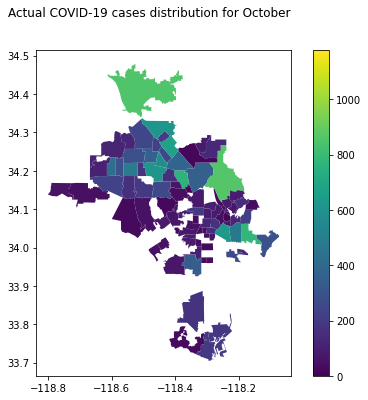

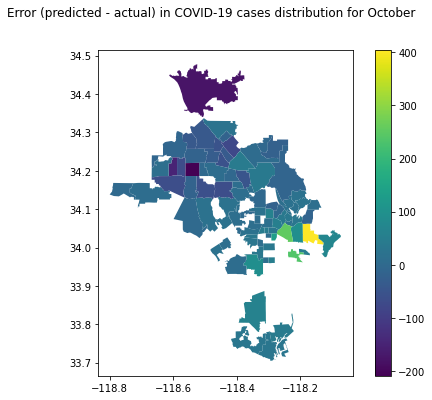

In [ ]:
train_model_single(wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1], lin_model, "LinReg: 4-Month Window (with static)", 10, wc4m_pty_arr[1], used_regions)

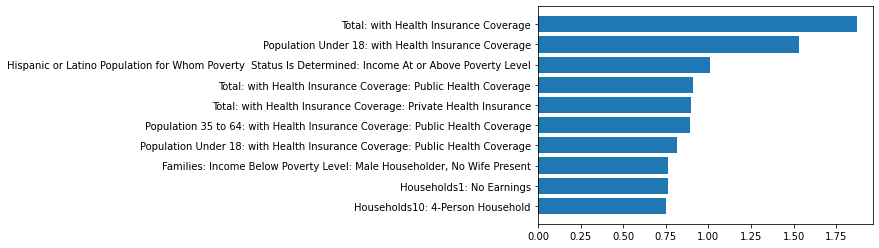

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 3-month window

### Feature Selection 1

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# lin_feat_subsets3_1 = f_selection(lin_model,wc3m_X_train_arr[0].shape[1],wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets3_1.npy', lin_feat_subsets3_1, allow_pickle=True)

['Area Total: Area (Water)' 'Total Population: Under 5 Years'
 'Total Population: 15 to 17 Years' 'Total Population: 25 to 34 Years'
 'Households: Family Households'
 'Households: Family Households: Married-Couple Family'
 'Households: Family Households: Other Family: Male Householder, No Wife Present'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Unemployed'
 'Population 16 Years and Over: Not in Labor Force'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administra

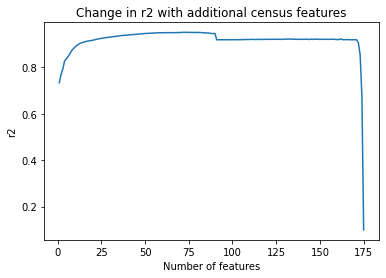

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets3_1.npy
lin_feat_subsets3_1 = np.load('../data/feat_selection/lin_feat_subsets3_1.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets3_1)

In [ ]:
month_data_oc, regions = build_month_data()

oc3m_X_train_arr, oc3m_X_test_arr, oc3m_y_train_arr, oc3m_y_test_arr, oc3m_ptX_arr, oc3m_pty_arr = n_month_window_split(month_data_oc, 3)
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

Carson
Culver City
Stevenson Ranch
South El Monte
Covina
Hawthorne
South Whittier
El Segundo
Athens
Duarte
Florence
Willowbrook
Valinda
Playa del Rey
Rolling Hills
Pasadena
Acton
Avalon
Avocado Heights
Lake Los Angeles
Angeles Crest
173


MSE: 243808.37610818585 
r2: 0.2389308503763028 
MAE: 374.4799188096212 
avg: 241.36666666666662


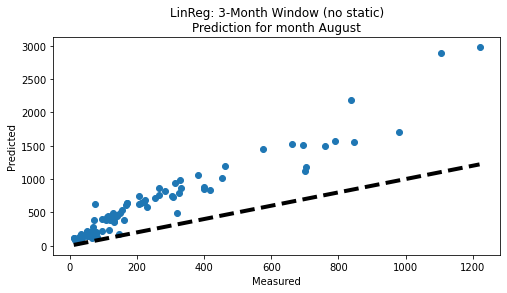

               region    Predicted  Actual  Error     % Error
16           Downtown  2887.177763    1104   1783  161.519725
19   East Los Angeles  2976.832331    1219   1757  144.202816
9       Boyle Heights  2192.350639     836   1356  162.242899
33    Huntington Park  1447.316414     573    874  152.585762
35          Inglewood  1519.744788     661    858  129.916004
..                ...          ...     ...    ...         ...
52  Pacific Palisades    78.836109      14     64  463.115062
6       Beverly Crest    78.835363      20     58  294.176815
0     Adams-Normandie   136.572020      81     55   68.607432
23     Elysian Valley   120.939314      66     54   83.241386
62       Shadow Hills    61.649545      20     41  208.247725

[89 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


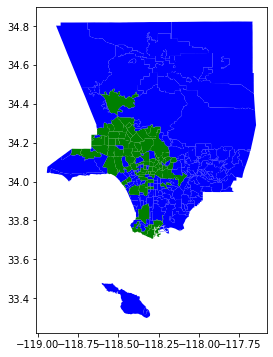

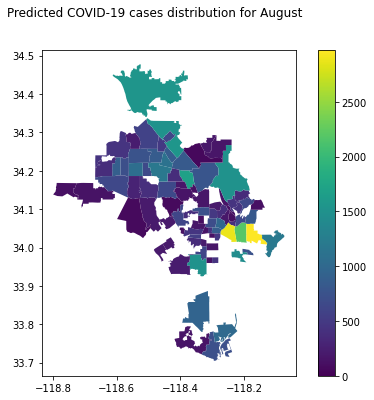

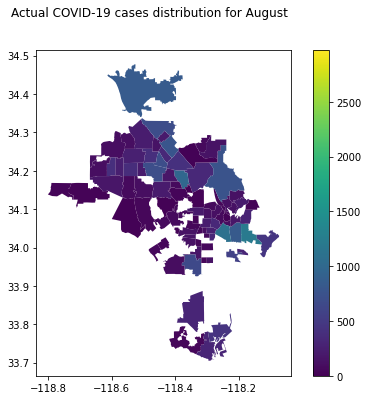

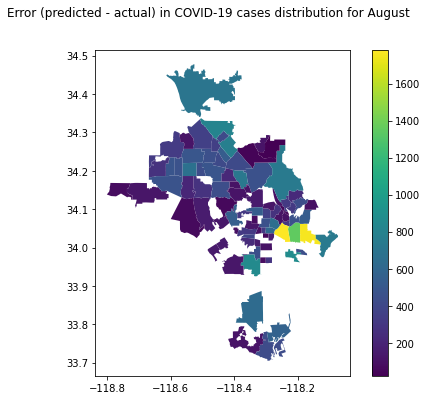

In [ ]:
train_model_single(nc3m_X_train_arr[0], nc3m_X_test_arr[0], nc3m_y_train_arr[0], nc3m_y_test_arr[0], lin_model, "LinReg: 3-Month Window (no static)", 8, nc3m_pty_arr[0], used_regions)


MSE: 4220.472036250441 
r2: 0.9337850638893295 
MAE: 42.14442209017167 
avg: 241.36666666666662


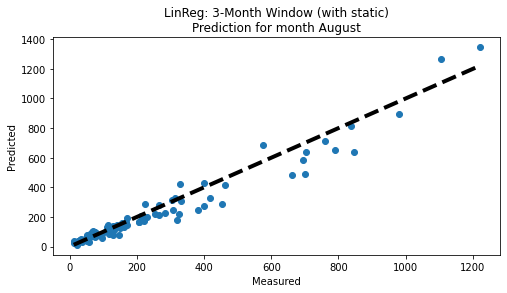

               region  Predicted  Actual  Error     % Error
38       Leimert Park  81.318240      51     30   59.447529
22       Elysian Park  39.206036      12     27  226.716964
31    Hollywood Hills  53.031170      34     19   55.974029
8         Beverlywood  36.206998      24     12   50.862491
71        Toluca Lake  23.724600      11     12  115.678185
52  Pacific Palisades  25.668620      14     11   83.347286


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


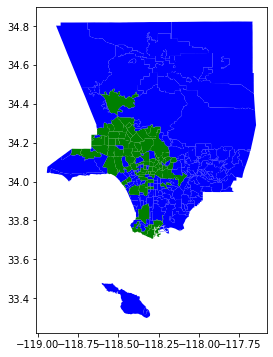

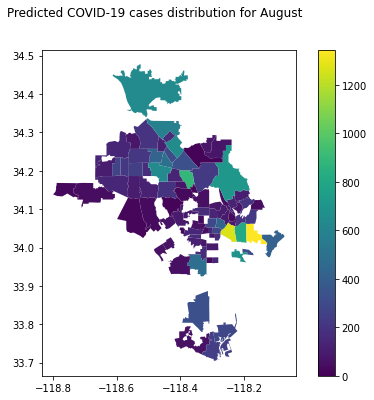

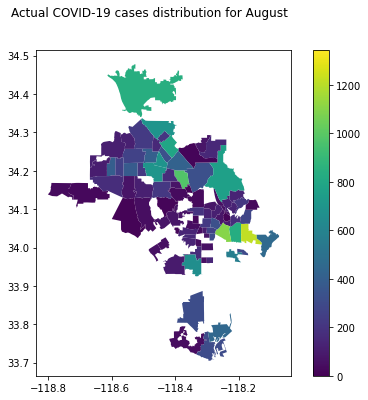

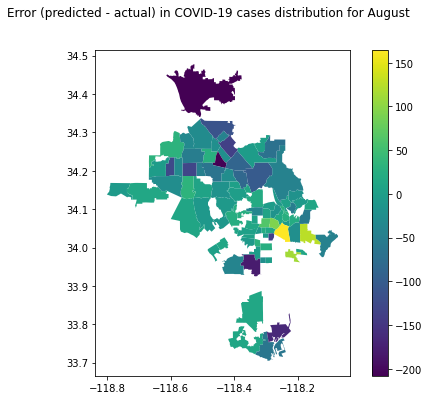

In [ ]:
train_model_single(wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0], lin_model, "LinReg: 3-Month Window (with static)", 8, wc3m_pty_arr[0], used_regions)

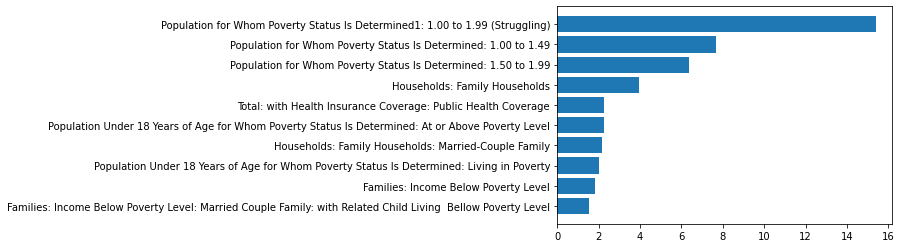

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# lin_feat_subsets3_2 = f_selection(lin_model,wc3m_X_train_arr[1].shape[1],wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1], True)

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets3_2.npy', lin_feat_subsets3_2, allow_pickle=True)

['cases' 'County total cases' 'Outgoing migration' 'Total jobs'
 'Healthcare workers' 'Area Total: Area (Water)'
 'Total Population: 45 to 54 Years' 'Total Population: 55 to 64 Years'
 'Total Population: 65 to 74 Years' 'Total Population: 75 to 84 Years'
 'Total Population: 85 Years and Over'
 'Households: Family Households: Married-Couple Family'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Employed'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodati

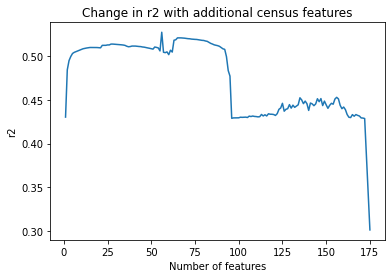

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets3_2.npy
lin_feat_subsets3_2 = np.load('../data/feat_selection/lin_feat_subsets3_2.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets3_2)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 23283.070892943902 
r2: 0.6095668922043374 
MAE: 104.82519718817588 
avg: 141.15555555555557


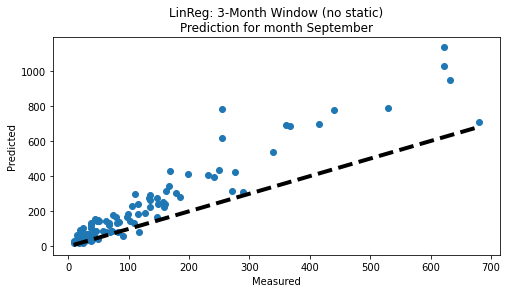

              region    Predicted  Actual  Error     % Error
9      Boyle Heights   780.726092     255    525  206.167095
19  East Los Angeles  1133.252470     621    512   82.488320
16          Downtown  1027.399532     622    405   65.176774
35         Inglewood   619.765893     255    364  143.045448
53           Pacoima   774.527572     439    335   76.429971
..               ...          ...     ...    ...         ...
67           Sunland    89.371745      58     31   54.089216
1       Agoura Hills    44.330143      14     30  216.643877
66       Studio City    48.472267      23     25  110.748986
62      Shadow Hills    29.352704       9     20  226.141153
22      Elysian Park    18.827676       9      9  109.196401

[65 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


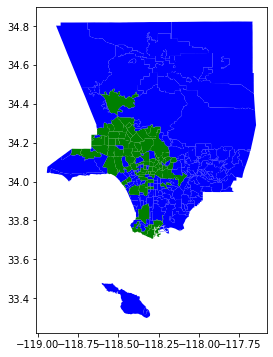

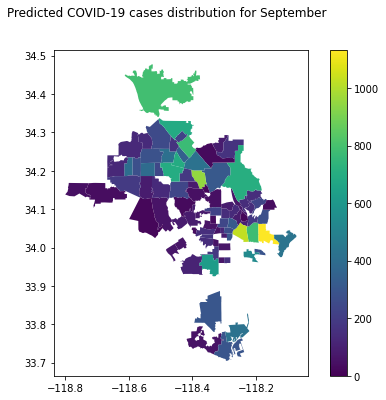

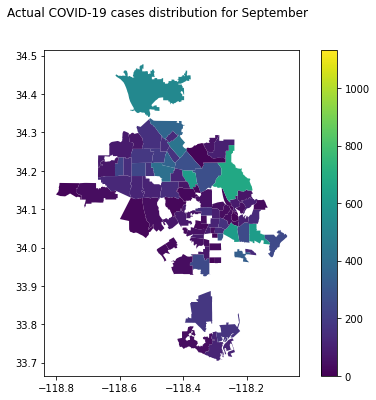

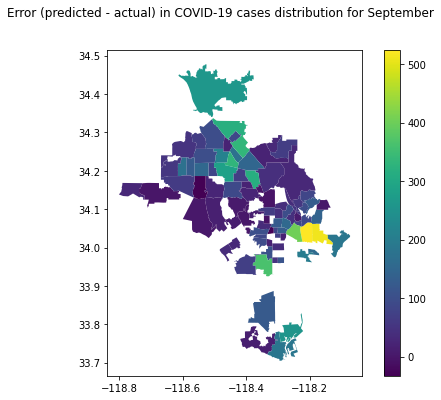

In [ ]:
train_model_single(nc3m_X_train_arr[1], nc3m_X_test_arr[1], nc3m_y_train_arr[1], nc3m_y_test_arr[1], lin_model, "LinReg: 3-Month Window (no static)", 9, nc3m_pty_arr[1], used_regions)


MSE: 32687.83831583938 
r2: 0.5677702664595641 
MAE: 117.03586639950394 
avg: 141.15555555555557


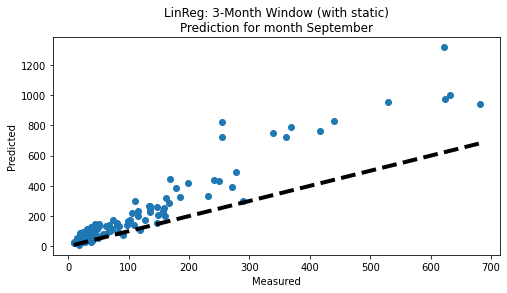

              region    Predicted  Actual  Error     % Error
19  East Los Angeles  1317.796949     621    696  112.205628
9      Boyle Heights   823.862769     255    568  223.083439
35         Inglewood   720.340058     255    465  182.486297
61     Santa Clarita   958.419744     528    430   81.518891
69            Sylmar   791.895141     368    423  115.188897
..               ...          ...     ...    ...         ...
66       Studio City    44.570760      23     21   93.785914
22      Elysian Park    27.609037       9     18  206.767076
1       Agoura Hills    28.974572      14     14  106.961226
71       Toluca Lake    36.935282      23     13   60.588181
62      Shadow Hills    21.620991       9     12  140.233230

[63 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


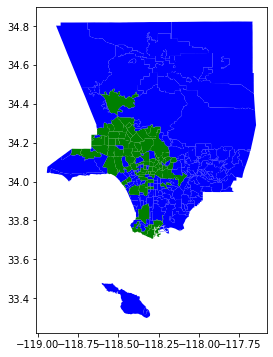

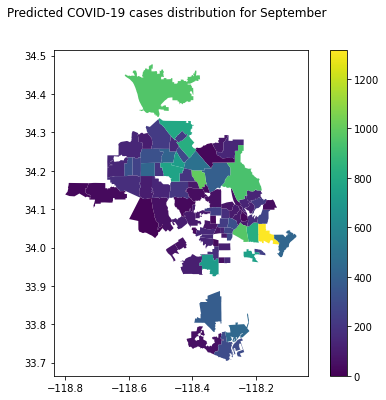

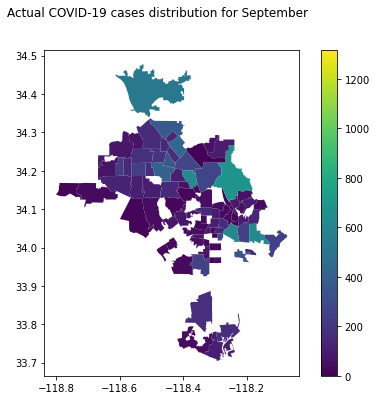

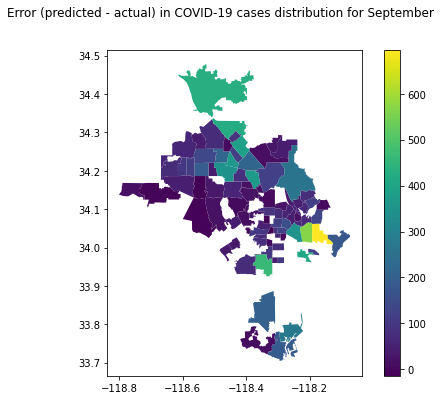

In [ ]:
train_model_single(wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1], lin_model, "LinReg: 3-Month Window (with static)", 9, wc3m_pty_arr[1], used_regions)


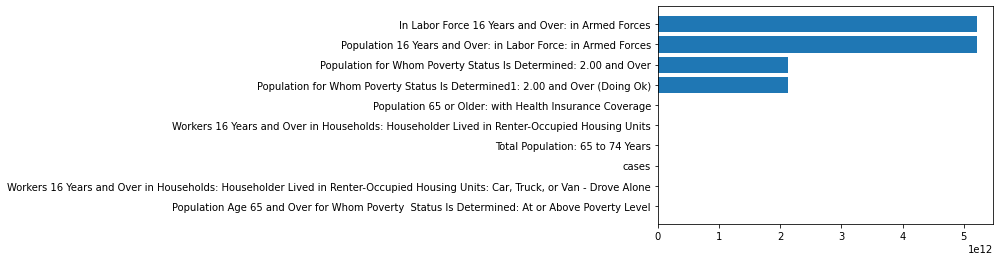

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 3

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# lin_feat_subsets3_3 = f_selection(lin_model,wc3m_X_train_arr[2].shape[1],wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2])

In [ ]:
# np.save('../data/feat_selection/lin_feat_subsets3_3.npy', lin_feat_subsets3_3, allow_pickle=True)

['cases' 'Incoming migration' 'Outgoing migration' 'Food Services workers'
 'Total Population: 15 to 17 Years' 'Total Population: 25 to 34 Years'
 'Households: Family Households: Other Family: Male Householder, No Wife Present'
 'Households: Nonfamily Households'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration'
 'Employed Civilian Population 16 Years and Over1: Private Sector'
 'Emp

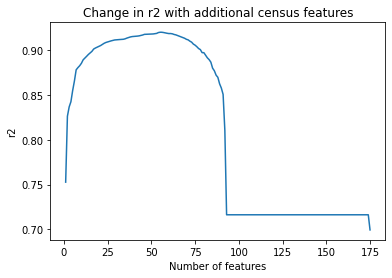

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/lin_feat_subsets3_3.npy
lin_feat_subsets3_3 = np.load('../data/feat_selection/lin_feat_subsets3_3.npy', allow_pickle=True)[()]
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets3_3)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 36834.152770881614 
r2: 0.5998076848285374 
MAE: 141.37936098204358 
avg: 193.5888888888889


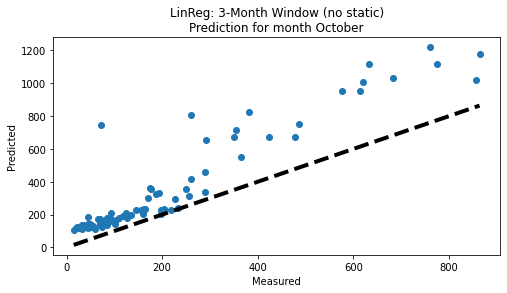

             region    Predicted  Actual  Error     % Error
74  University Park   742.920845      72    670  931.834508
33  Huntington Park   808.744598     260    548  211.055614
16         Downtown  1117.351639     633    484   76.516847
50  North Hollywood  1219.636513     761    458   60.267610
68       Sun Valley   826.767778     381    445  116.999417
..              ...          ...     ...    ...         ...
82      Westchester   133.873216      70     63   91.247451
84   West Hollywood   163.219034     102     61   60.018660
1      Agoura Hills   113.226711      59     54   91.909680
64      Silver Lake   136.835059      85     51   60.982422
15        Chinatown   124.056272      74     50   67.643611

[70 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


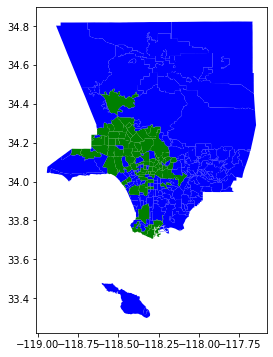

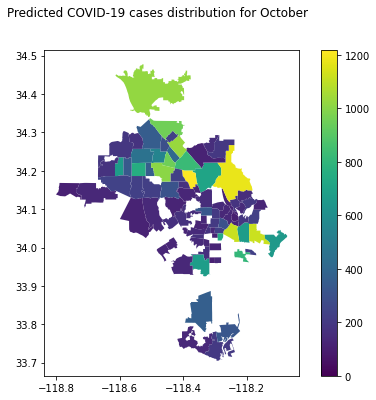

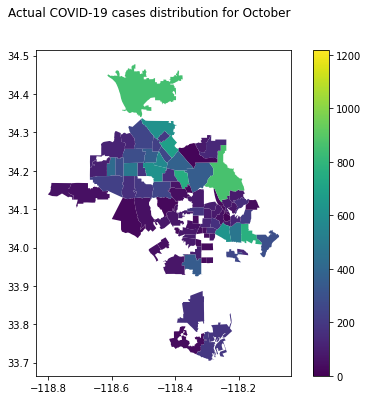

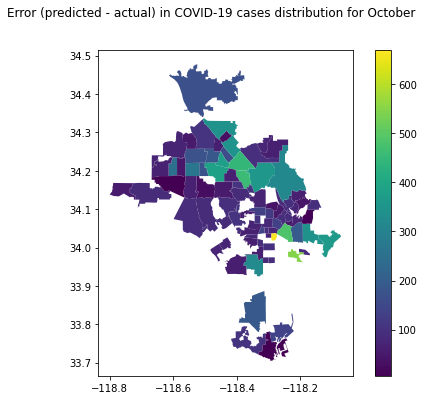

In [ ]:
train_model_single(nc3m_X_train_arr[2], nc3m_X_test_arr[2], nc3m_y_train_arr[2], nc3m_y_test_arr[2], lin_model, "LinReg: 3-Month Window (no static)", 10, nc3m_pty_arr[2], used_regions)


MSE: 4049.618472119421 
r2: 0.8930134485742196 
MAE: 39.935190127774185 
avg: 193.5888888888889


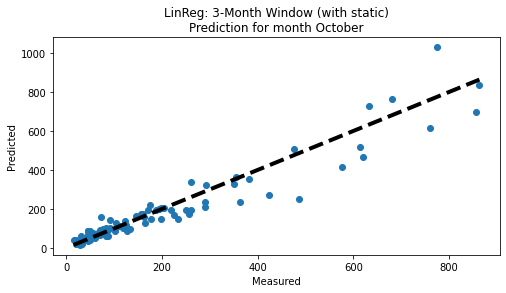

               region   Predicted  Actual  Error     % Error
74    University Park  157.562767      72     85  118.837177
18     East Hollywood  144.707684      91     53   59.019433
29    Harvard Heights   87.201990      44     43   98.186340
79     Vermont Knolls   86.436781      44     42   96.447230
3   Arlington Heights   85.559886      44     41   94.454287
20          Echo Park   87.894922      48     39   83.114421
80     Vermont Square   60.475993      30     30  101.586642
10          Brentwood   76.294982      50     26   52.589965
22       Elysian Park   39.818922      14     25  184.420871
71        Toluca Lake   37.830667      20     17   89.153337


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


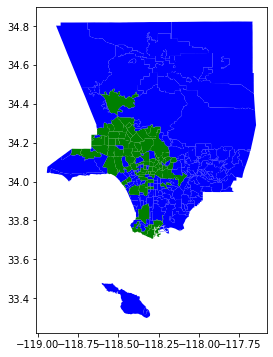

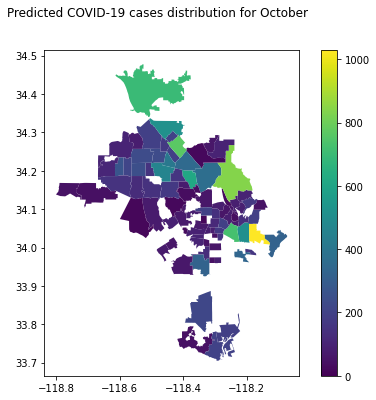

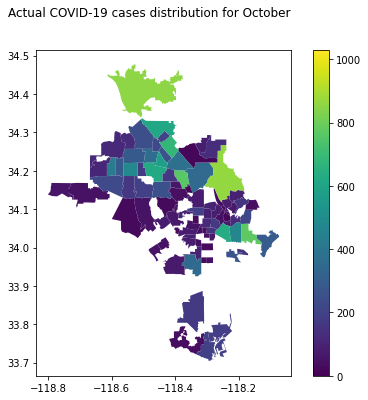

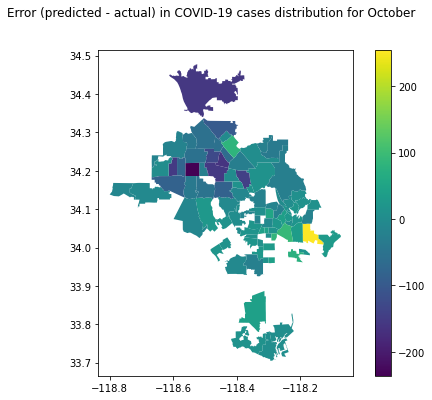

In [ ]:
train_model_single(wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2], lin_model, "LinReg: 3-Month Window (with static)", 10, wc3m_pty_arr[2], used_regions)


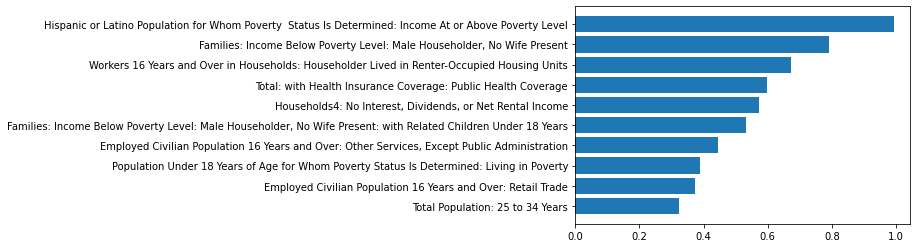

In [ ]:
feat_im_df = f_importances(lin_model, lin_feat_names, 'linear')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

# SVR

In [ ]:
svr_params = {
    'C': 1,
    'gamma': 0.0001,
    'kernel': 'linear',
}

# svr_params = {
#     'C': 1,
#     'gamma': 0.5,
#     'kernel': 'linear',
# }
svr_model = SVR(**svr_params)

### Cases Only

Carson
Culver City
Stevenson Ranch
South El Monte
Covina
Hawthorne
South Whittier
El Segundo
Athens
Duarte
Florence
Willowbrook
Valinda
Playa del Rey
Rolling Hills
Pasadena
Acton
Avalon
Avocado Heights
Lake Los Angeles
Angeles Crest
173
MSE: [17484.407478747624]; avg = 17484.407478747624 
r2: [-0.14848459326676045]; avg = -0.14848459326676045
MAE: [95.34962664088586]; avg = 95.34962664088586
avg: [180.364161849711]; avg = 180.364161849711


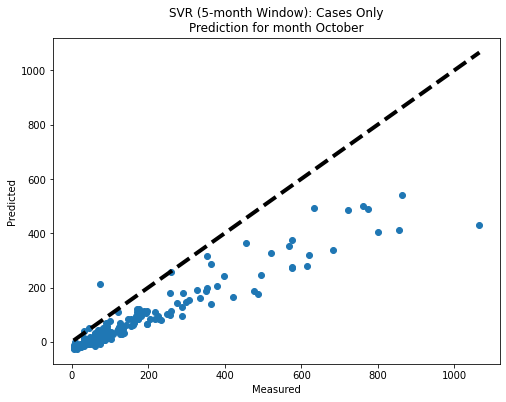

In [ ]:
month_data, regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases Only", 5)

### Add Normalization

Carson
Culver City
Stevenson Ranch
South El Monte
Covina
Hawthorne
South Whittier
El Segundo
Athens
Duarte
Florence
Willowbrook
Valinda
Playa del Rey
Rolling Hills
Pasadena
Acton
Avalon
Avocado Heights
Lake Los Angeles
Angeles Crest
173
MSE: [4255.609556428823]; avg = 4255.609556428823 
r2: [0.8636348287580139]; avg = 0.8636348287580139
MAE: [38.62056736002866]; avg = 38.62056736002866
avg: [180.364161849711]; avg = 180.364161849711


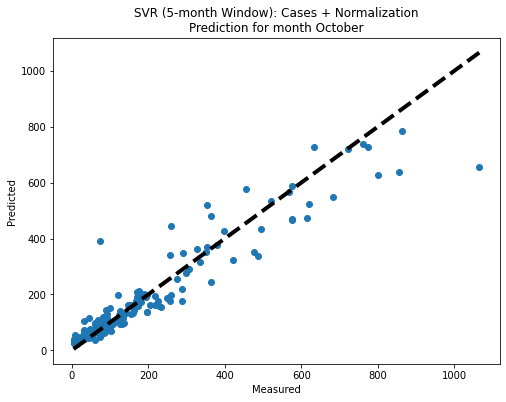

                    region   Predicted  Actual  Error     % Error
149        University Park  391.564195      73    318  436.389308
68         Huntington Park  445.153309     260    185   71.212811
26                 Castaic  196.856254     120     76   64.046878
6        Arlington Heights  117.545574      45     72  161.212386
7                  Artesia  104.056920      32     72  225.177876
53                Glendora  143.603874      90     53   59.559860
50                 Gardena  151.989604      99     52   53.524853
114            Playa Vista   54.462977       8     46  580.787212
62        Hawaiian Gardens   73.030971      31     42  135.583776
17           Beverly Hills  108.203797      69     39   56.817097
126            San Gabriel   96.806407      61     35   58.699027
127             San Marino   40.038725       7     33  471.981783
75    La Canada Flintridge   92.666645      60     32   54.444409
117    Rancho Palos Verdes   66.838430      35     31   90.966943
109   Palo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


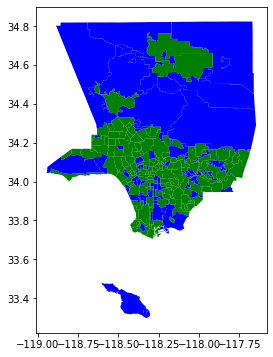

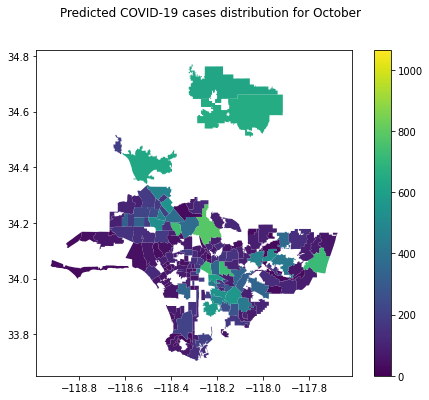

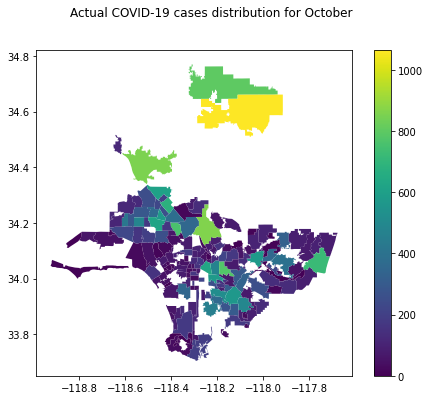

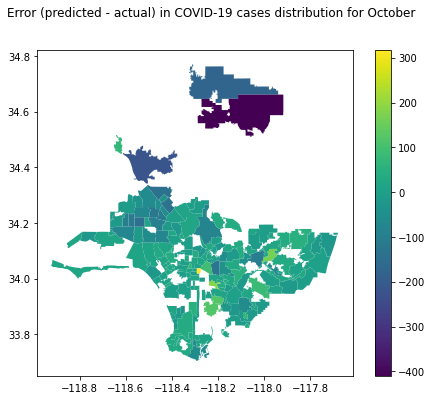

In [ ]:
month_data, regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization", nc5m_pty_arr, 5, regions)

### Add Migration

Pasadena
90
MSE: [4599.872023340318]; avg = 4599.872023340318 
r2: [0.8388610769565876]; avg = 0.8388610769565876
MAE: [42.12358710491859]; avg = 42.12358710491859
avg: [193.5888888888889]; avg = 193.5888888888889


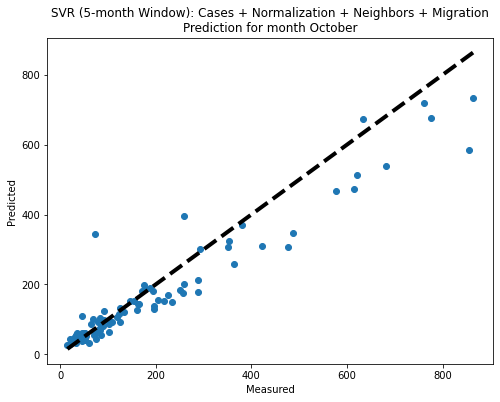

                 region   Predicted  Actual  Error     % Error
74      University Park  344.203098      73    271  371.511094
33      Huntington Park  395.795498     260    135   52.229038
3     Arlington Heights  108.979318      45     63  142.176263
57  Rancho Palos Verdes   59.678927      35     24   70.511221
28         Hancock Park   56.152848      33     23   70.160144
71          Toluca Lake   42.745895      21     21  103.551880
80       Vermont Square   48.924699      31     17   57.821611
8           Beverlywood   45.953963      29     16   58.461942
6         Beverly Crest   39.932355      26     13   53.585981
22         Elysian Park   26.970419      15     11   79.802794
62         Shadow Hills   30.351257      20     10   51.756283


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


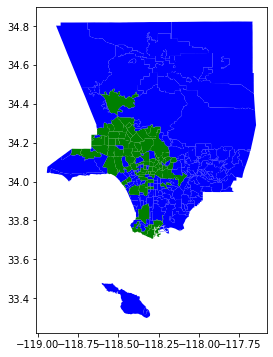

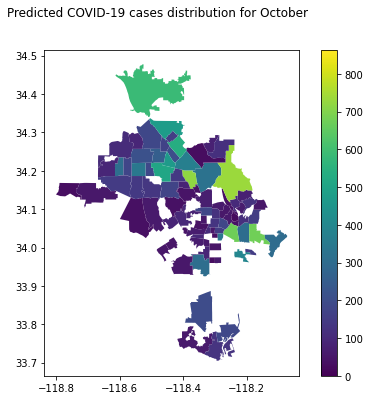

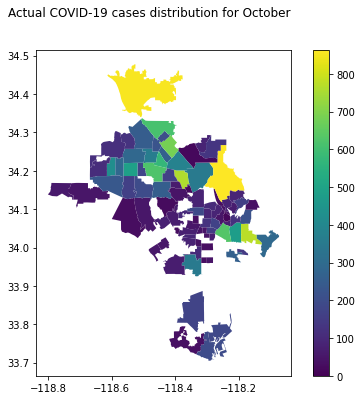

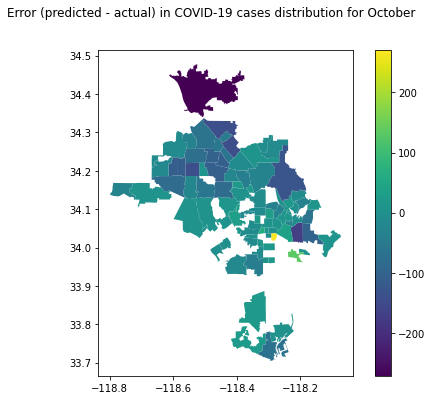

In [ ]:
month_data, used_regions = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5, used_regions)

### Add Census

Pasadena
90
MSE: [10722.418976925477]; avg = 10722.418976925477 
r2: [0.7392896637770329]; avg = 0.7392896637770329
MAE: [62.313343157415]; avg = 62.313343157415
avg: [193.5888888888889]; avg = 193.5888888888889


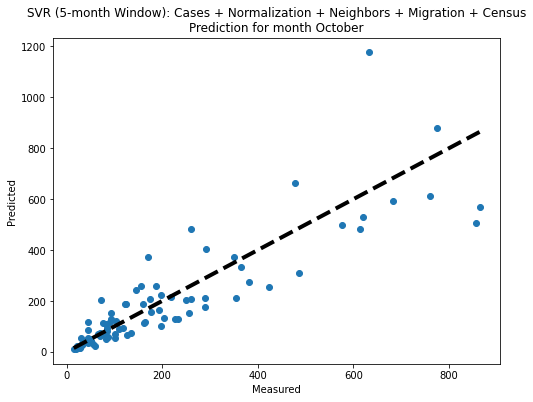

             region    Predicted  Actual  Error     % Error
16         Downtown  1176.228908     633    543   85.818153
33  Huntington Park   480.841796     260    220   84.939152
85         Westlake   373.357382     171    202  118.337650
74  University Park   204.000081      73    131  179.452166
55       Pico-Union   258.148297     155    103   66.547289
43          Maywood   241.982057     146     95   65.741135
79   Vermont Knolls   119.209726      45     74  164.910502
39  Lincoln Heights   188.130252     123     65   52.951425
18   East Hollywood   150.709102      92     58   63.814241
29  Harvard Heights    86.681017      45     41   92.624482
80   Vermont Square    54.636864      31     23   76.247949
1      Agoura Hills    21.492555      60    -38   64.179074


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


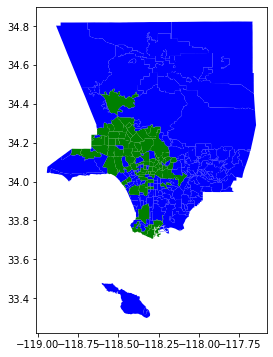

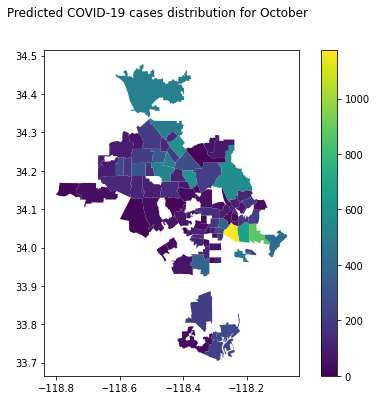

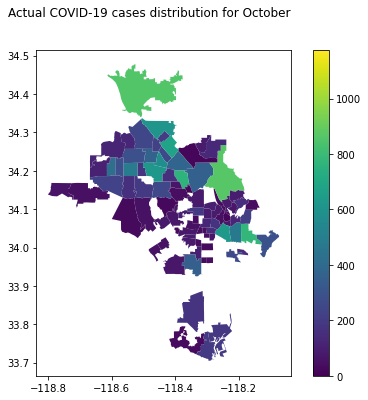

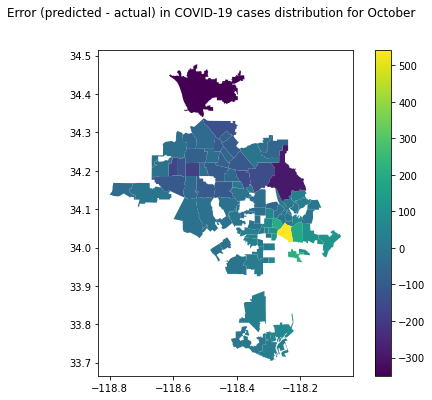

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5, used_regions)

### Feature Selection

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
# svr_feat_subsets = f_selection(svr_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_X_test_arr[0],nc5m_y_train_arr[0], nc5m_y_test_arr[0])

In [ ]:
# np.save('../data/svr_feat_subsets.npy',svr_feat_subsets, allow_pickle=True)

In [ ]:
!wget --directory-prefix=../data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets.npy
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]

Pasadena
90
['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Total Population: Under 5 Years' 'Total Population: 10 to 14 Years'
 'Total Population: 15 to 17 Years'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Households6: with Supplemental Security Income (Ssi)'
 'Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty'
 'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level'
 'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level'
 'American Indian and Alaska Native Alone  Population For&nbsp;

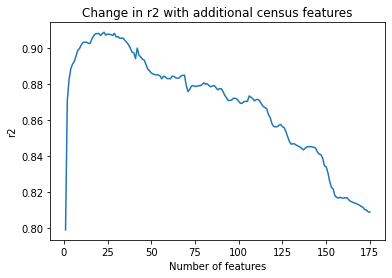

MSE: [4108.053629260438]; avg = 4108.053629260438 
r2: [0.8654595905914892]; avg = 0.8654595905914892
MAE: [40.799118946941014]; avg = 40.799118946941014
avg: [193.5888888888889]; avg = 193.5888888888889


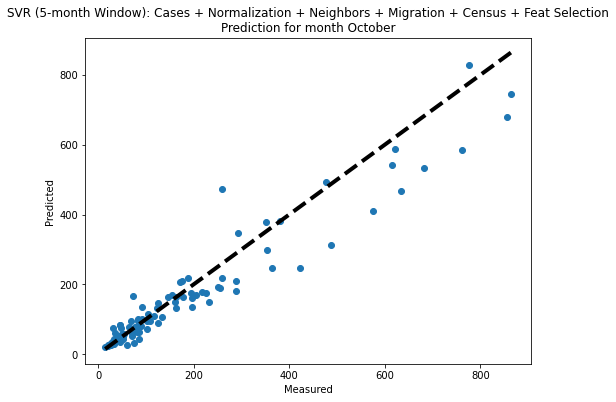

                 region   Predicted  Actual  Error     % Error
33      Huntington Park  473.326486     260    213   82.048649
74      University Park  165.847781      73     92  127.188741
80       Vermont Square   74.430315      31     43  140.097790
79       Vermont Knolls   84.216154      45     39   87.147009
3     Arlington Heights   83.920344      45     38   86.489652
20            Echo Park   75.089795      49     26   53.244479
57  Rancho Palos Verdes   59.350089      35     24   69.571683
1          Agoura Hills   27.615013      60    -32   53.974979
15            Chinatown   33.528275      75    -41   55.295634


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


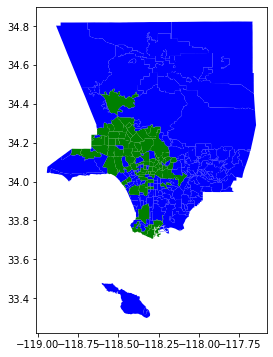

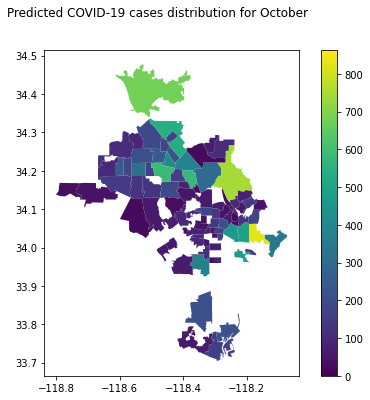

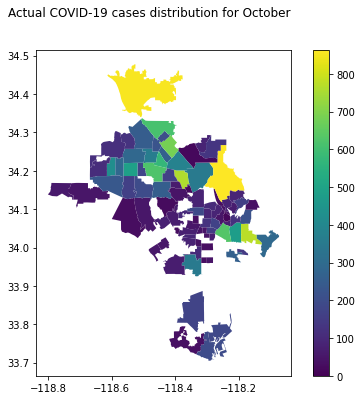

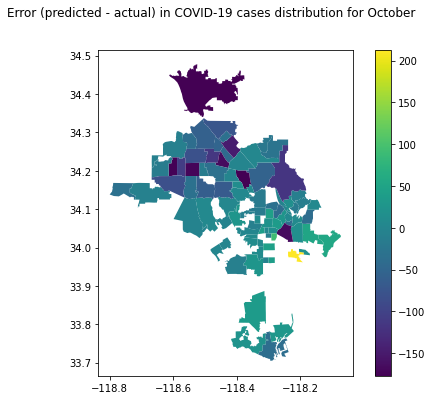

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR (5-month Window): Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5, used_regions)

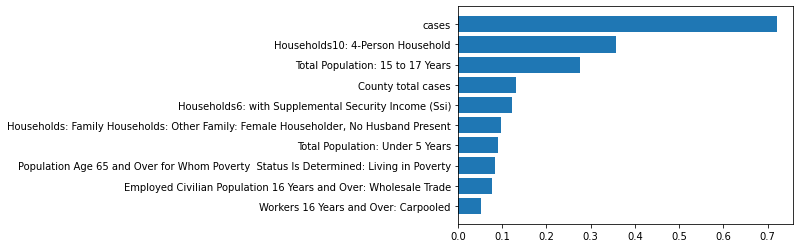

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
# svr_param_grid = {
#     'C':[1,5,10,20,30,50],
#     'gamma': [10,5, 1, 0.01, 0.0001],
#     'kernel': ['linear']
# }

# svr_model = SVR()
# svr_search = GridSearchCV(svr_model, svr_param_grid)

In [ ]:
# search_model(nc5m_X_train_arr[0], nc5m_X_test_arr[0], nc5m_y_train_arr[0], nc5m_y_test_arr[0], svr_search, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection + Local Search")

## 5-month window

### Feature Selection

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data, 5)
# svr_feat_subsets5 = f_selection(svr_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_X_test_arr[0],wc5m_y_train_arr[0],wc5m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets5.npy', svr_feat_subsets5, allow_pickle=True)

['cases' 'County total cases' 'Incoming migration' 'Outgoing migration'
 'Total Population: Under 5 Years' 'Total Population: 10 to 14 Years'
 'Total Population: 15 to 17 Years'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Wholesale Trade'
 'Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities'
 'Households6: with Supplemental Security Income (Ssi)'
 'Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty'
 'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level'
 'American Indian and Alaska Native Alone  Population For&nbsp; Whom Poverty Status Is Determined: Income Below Poverty Level'
 'American Indian and Alaska Native Alone  Population For&nbsp; Whom Povert

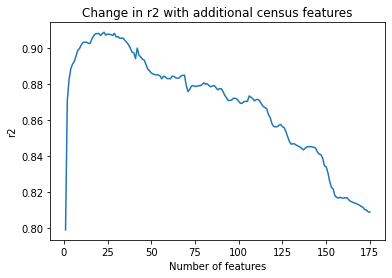

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets5.npy
svr_feat_subsets5 = np.load('../data/feat_selection/svr_feat_subsets5.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets5)

In [ ]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

MSE: [4599.872023340318]; avg = 4599.872023340318 
r2: [0.8388610769565876]; avg = 0.8388610769565876
MAE: [42.12358710491859]; avg = 42.12358710491859
avg: [193.5888888888889]; avg = 193.5888888888889


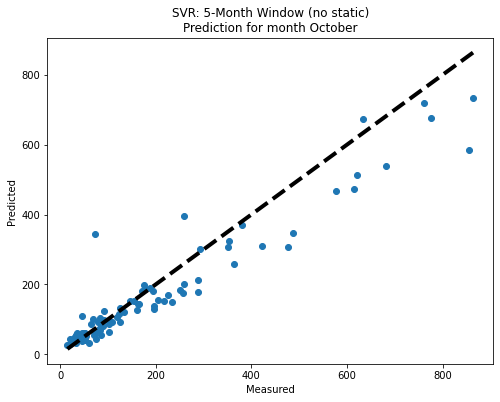

                 region   Predicted  Actual  Error     % Error
74      University Park  344.203098      73    271  371.511094
33      Huntington Park  395.795498     260    135   52.229038
3     Arlington Heights  108.979318      45     63  142.176263
57  Rancho Palos Verdes   59.678927      35     24   70.511221
28         Hancock Park   56.152848      33     23   70.160144
71          Toluca Lake   42.745895      21     21  103.551880
80       Vermont Square   48.924699      31     17   57.821611
8           Beverlywood   45.953963      29     16   58.461942
6         Beverly Crest   39.932355      26     13   53.585981
22         Elysian Park   26.970419      15     11   79.802794
62         Shadow Hills   30.351257      20     10   51.756283


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


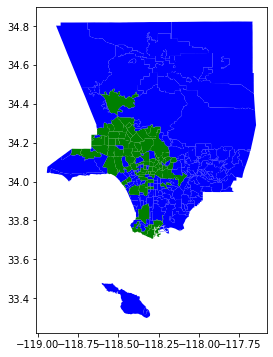

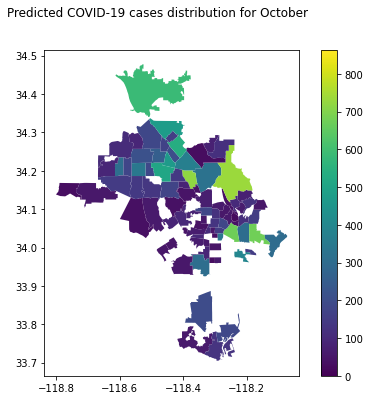

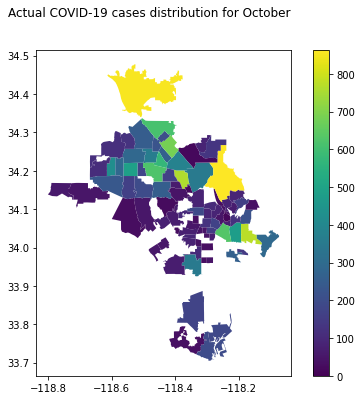

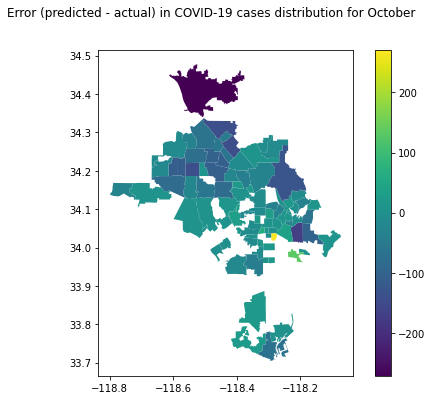

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, svr_model, "SVR: 5-Month Window (no static)", nc5m_pty_arr, 5, used_regions)

MSE: [4108.053629260438]; avg = 4108.053629260438 
r2: [0.8654595905914892]; avg = 0.8654595905914892
MAE: [40.799118946941014]; avg = 40.799118946941014
avg: [193.5888888888889]; avg = 193.5888888888889


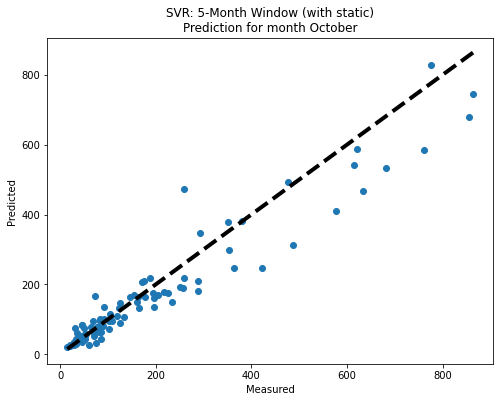

                 region   Predicted  Actual  Error     % Error
33      Huntington Park  473.326486     260    213   82.048649
74      University Park  165.847781      73     92  127.188741
80       Vermont Square   74.430315      31     43  140.097790
79       Vermont Knolls   84.216154      45     39   87.147009
3     Arlington Heights   83.920344      45     38   86.489652
20            Echo Park   75.089795      49     26   53.244479
57  Rancho Palos Verdes   59.350089      35     24   69.571683
1          Agoura Hills   27.615013      60    -32   53.974979
15            Chinatown   33.528275      75    -41   55.295634


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


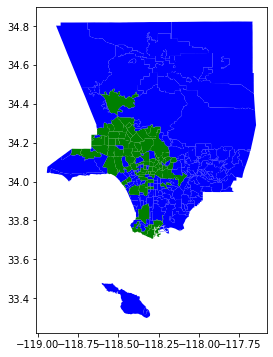

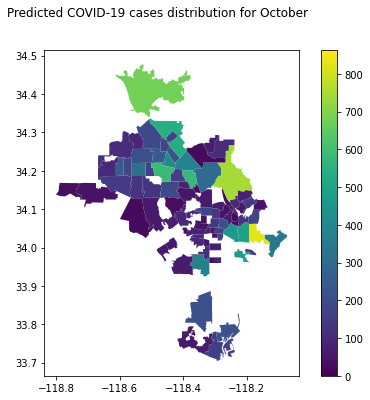

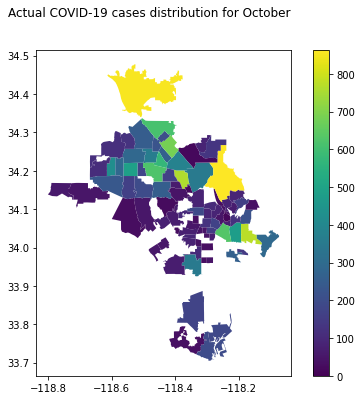

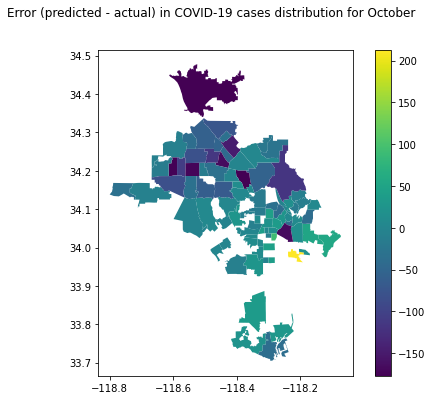

In [ ]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, svr_model, "SVR: 5-Month Window (with static)", wc5m_pty_arr, 5, used_regions)

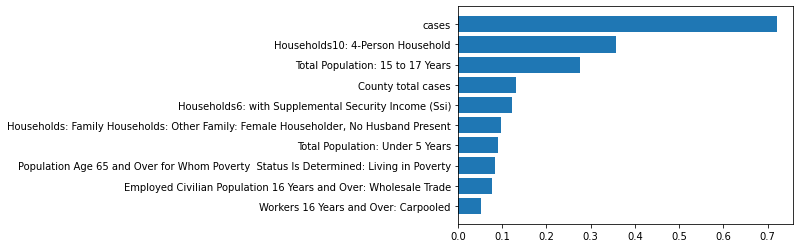

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 4-month window

### Feature Selection 1

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# svr_feat_subsets4_1 = f_selection(svr_model,wc4m_X_train_arr[0].shape[1],wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets4_1.npy', svr_feat_subsets4_1, allow_pickle=True)

['cases' 'County total cases' 'Outgoing migration' 'Total jobs'
 'Healthcare workers' 'Area Total: Area (Water)'
 'Total Population: Under 5 Years' 'Total Population: 5 to 9 Years'
 'Total Population: 10 to 14 Years' 'Total Population: 15 to 17 Years'
 'Total Population: 35 to 44 Years' 'Households: Nonfamily Households'
 'Population 16 Years and Over: in Labor Force'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian: Employed'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services'
 'Employed Civilian Population 16 Years and Over: Public Administration'
 'Employed Civilian Population 16 Years and Over1: Public Sector'
 'E

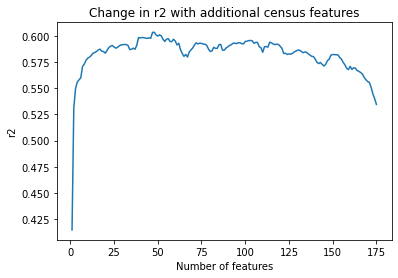

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets4_1.npy
svr_feat_subsets4_1 = np.load('../data/feat_selection/svr_feat_subsets4_1.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets4_1)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 22969.00556217408 
r2: 0.6257128548205655 
MAE: 101.06150103032962 
avg: 141.15555555555557


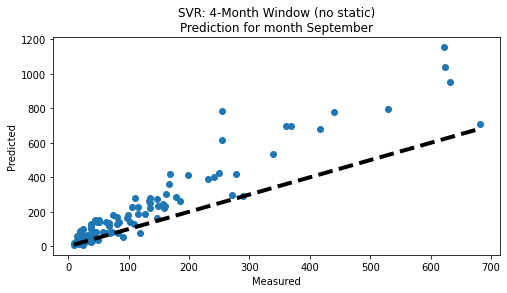

                    region    Predicted  Actual  Error     % Error
19        East Los Angeles  1154.277650     622    532   85.575185
9            Boyle Heights   781.865649     255    526  206.613980
16                Downtown  1040.709760     623    417   67.048116
35               Inglewood   617.036053     255    362  141.974923
53                 Pacoima   780.609726     439    341   77.815427
54           Panorama City   699.056857     361    338   93.644559
69                  Sylmar   696.294873     368    328   89.210563
50         North Hollywood   950.898588     632    318   50.458637
61           Santa Clarita   795.131665     529    266   50.308443
77                Van Nuys   680.579178     416    264   63.600764
87              Wilmington   416.391087     169    247  146.385259
49             North Hills   411.218690     199    212  106.642558
33         Huntington Park   532.808763     339    193   57.170727
2                   Arleta   359.109085     167    192  115.03

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


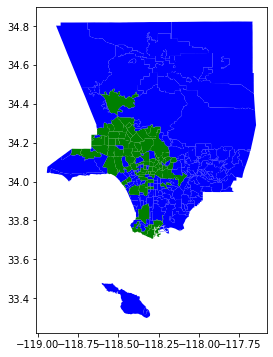

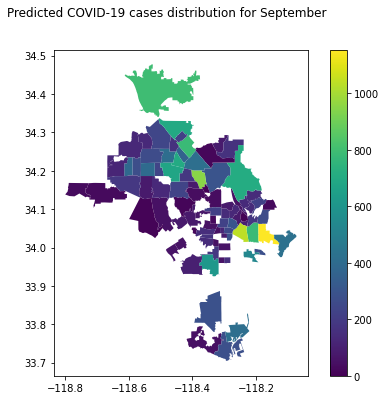

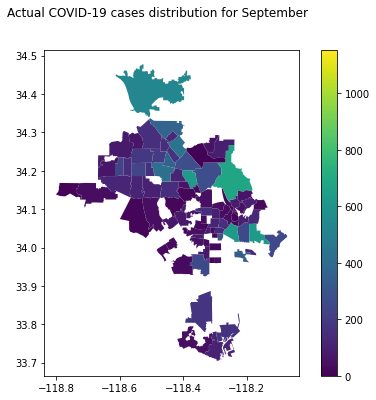

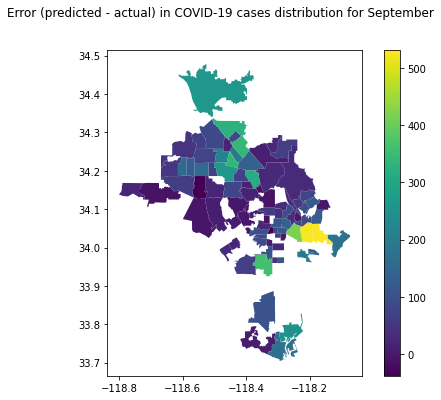

In [ ]:
train_model_single(nc4m_X_train_arr[0], nc4m_X_test_arr[0], nc4m_y_train_arr[0], nc4m_y_test_arr[0], svr_model, "SVR: 4-Month Window (no static)", 9, nc4m_pty_arr[0], used_regions)

MSE: 19823.213975460847 
r2: 0.6359155077224161 
MAE: 90.47943230097486 
avg: 141.15555555555557


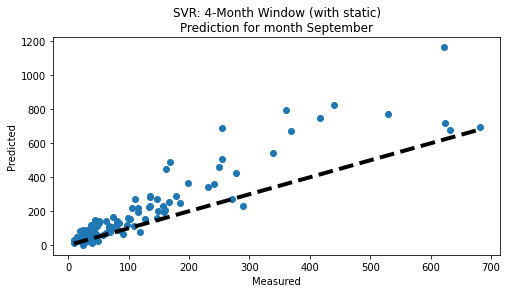

                    region    Predicted  Actual  Error     % Error
19        East Los Angeles  1165.555606     622    543   87.388361
9            Boyle Heights   692.275973     255    437  171.480774
54           Panorama City   795.226161     361    434  120.284255
53                 Pacoima   827.446821     439    388   88.484469
77                Van Nuys   745.994189     416    329   79.325526
87              Wilmington   491.235033     169    322  190.671617
69                  Sylmar   670.742161     368    302   82.266892
85                Westlake   445.954116     162    283  175.280319
35               Inglewood   506.958641     255    251   98.807310
47              Montebello   460.595197     249    211   84.977991
33         Huntington Park   544.566472     339    205   60.639077
49             North Hills   364.958064     199    165   83.396012
60               San Pedro   270.144422     110    160  145.585838
55              Pico-Union   290.660478     135    155  115.30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


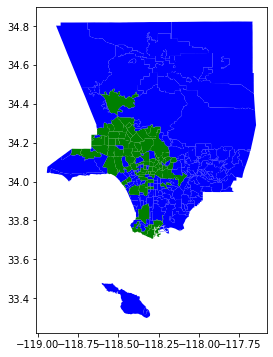

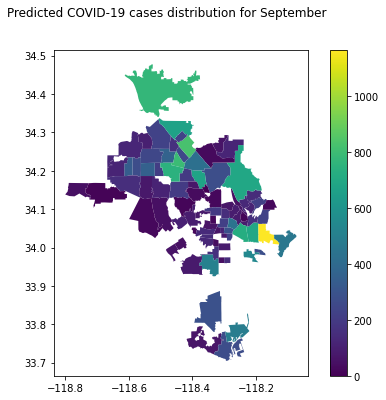

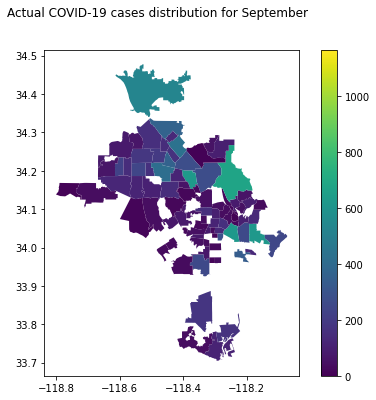

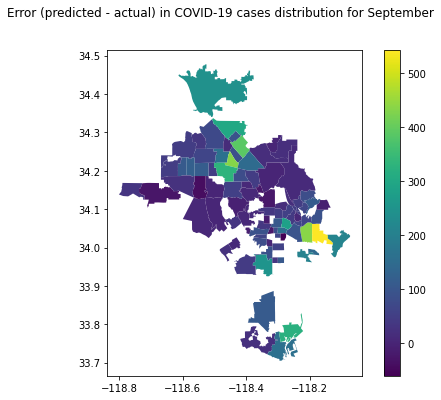

In [ ]:
train_model_single(wc4m_X_train_arr[0], wc4m_X_test_arr[0], wc4m_y_train_arr[0], wc4m_y_test_arr[0], svr_model, "SVR: 4-Month Window (with static)", 9, wc4m_pty_arr[0], used_regions)

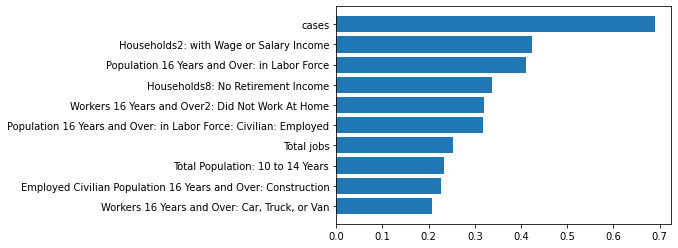

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data, 4)
# svr_feat_subsets4_2 = f_selection(svr_model,wc4m_X_train_arr[1].shape[1],wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets4_2.npy', svr_feat_subsets4_2, allow_pickle=True)

['cases' 'County total cases' 'Total Population: Under 5 Years'
 'Total Population: 10 to 14 Years' 'Total Population: 15 to 17 Years'
 'Households: Nonfamily Households: Female Householder'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance'
 'Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration'
 'Employed Civilian Population 16 Years and Over1: Private Sector'
 'Employed Civilian Population 16 Years and Over1: Unpaid Family Workers'
 'Households1: No Earnings' 'Households3: No Self-Employment Income'
 'Households5: No Social Security Income'
 'Households6: with Supplemental Security Income (Ssi)'
 'Households9: with Other Types of Income'
 'Black or Afric

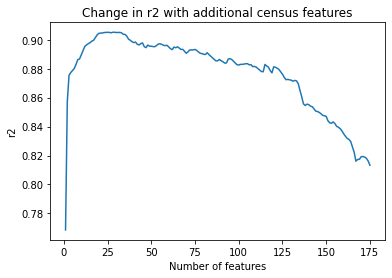

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets4_2.npy
svr_feat_subsets4_2 = np.load('../data/feat_selection/svr_feat_subsets4_2.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets4_2)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

MSE: 4342.865403800369 
r2: 0.8642570029741048 
MAE: 42.786892922613326 
avg: 193.5888888888889


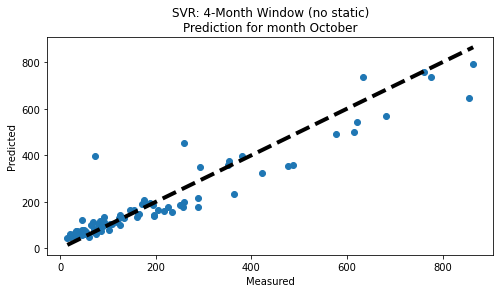

                 region   Predicted  Actual  Error     % Error
74      University Park  396.894458      73    323  443.691038
33      Huntington Park  451.497902     260    191   73.653039
3     Arlington Heights  122.074628      45     77  171.276951
7         Beverly Hills  113.708213      69     44   64.794512
57  Rancho Palos Verdes   76.599542      34     42  125.292772
28         Hancock Park   73.100878      33     40  121.517813
71          Toluca Lake   60.323970      21     39  187.257002
8           Beverlywood   63.843350      28     35  128.011966
80       Vermont Square   66.589291      31     35  114.804165
76       Valley Village   98.552363      65     33   51.619019
79       Vermont Knolls   78.483112      45     33   74.406916
6         Beverly Crest   58.315566      26     32  124.290640
22         Elysian Park   46.391899      15     31  209.279328
38         Leimert Park   74.868710      43     31   74.113280
65       South Pasadena   69.357022      39     30   77

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


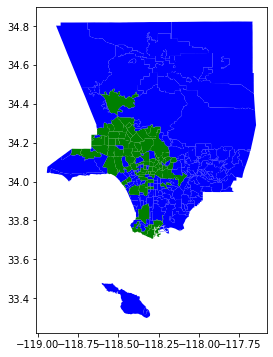

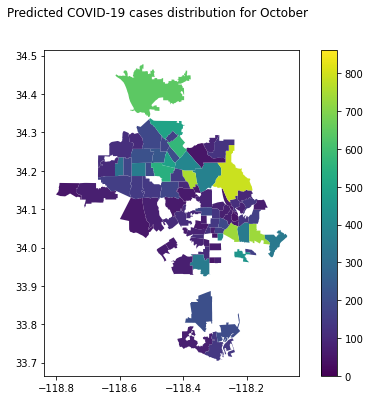

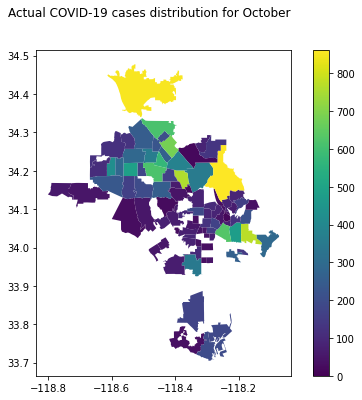

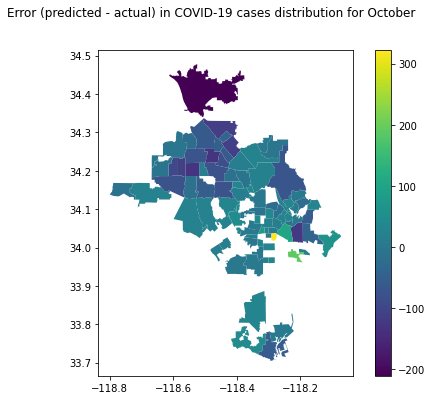

In [ ]:
train_model_single(nc4m_X_train_arr[1], nc4m_X_test_arr[1], nc4m_y_train_arr[1], nc4m_y_test_arr[1], svr_model, "SVR: 4-Month Window (no static)", 10, nc4m_pty_arr[1], used_regions)


MSE: 2588.117630749311 
r2: 0.9293904280174524 
MAE: 35.902209809923754 
avg: 193.5888888888889


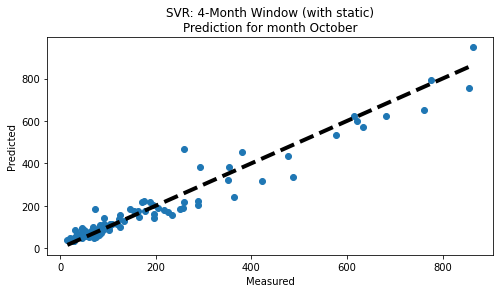

                 region   Predicted  Actual  Error     % Error
33      Huntington Park  469.051077     260    209   80.404260
74      University Park  184.781158      73    111  153.124874
80       Vermont Square   86.277526      31     55  178.314600
18       East Hollywood  142.844162      92     50   55.265393
79       Vermont Knolls   95.586254      45     50  112.413897
3     Arlington Heights   90.381030      45     45  100.846733
20            Echo Park   84.826158      49     35   73.114607
57  Rancho Palos Verdes   67.275047      34     33   97.867784
29      Harvard Heights   75.726913      45     30   68.282028
10            Brentwood   80.686355      51     29   58.208539
71          Toluca Lake   47.322189      21     26  125.343759
62         Shadow Hills   44.327926      20     24  121.639630
22         Elysian Park   38.665528      15     23  157.770188
28         Hancock Park   54.772930      33     21   65.978576
65       South Pasadena   58.921773      39     19   51

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


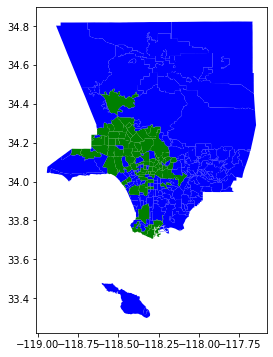

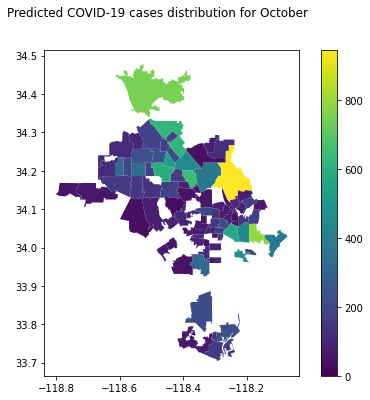

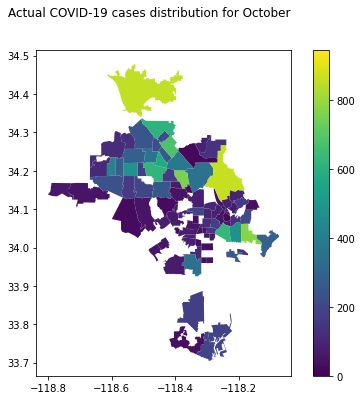

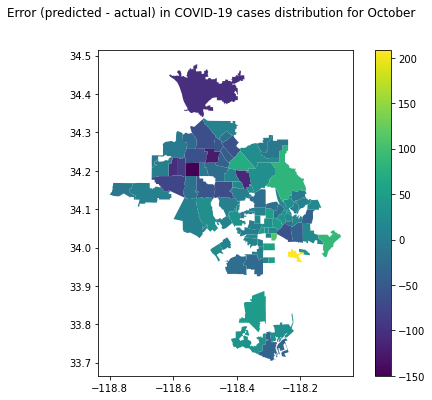

In [ ]:
train_model_single(wc4m_X_train_arr[1], wc4m_X_test_arr[1], wc4m_y_train_arr[1], wc4m_y_test_arr[1], svr_model, "SVR: 4-Month Window (with static)", 10, wc4m_pty_arr[1], used_regions)


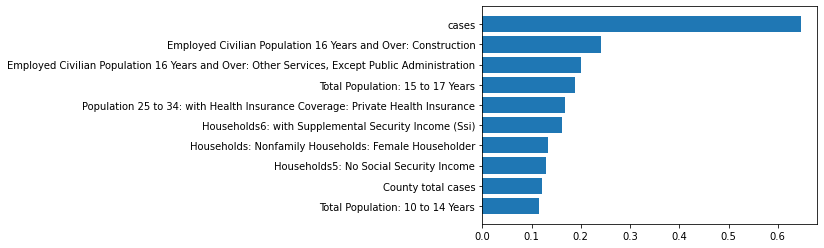

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

## 3-month window

### Feature Selection 1

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# svr_feat_subsets3_1 = f_selection(svr_model,wc3m_X_train_arr[0].shape[1],wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets3_1.npy', svr_feat_subsets3_1, allow_pickle=True)

['Total jobs' 'Area Total: Area (Land)' 'Area Total: Area (Water)'
 'Total Population: 18 to 24 Years' 'Total Population: 65 to 74 Years'
 'Total Population: 75 to 84 Years' 'Households: Family Households'
 'Households: Family Households: Other Family'
 'Households: Nonfamily Households'
 'Households: Nonfamily Households: Male Householder'
 'Households: Nonfamily Households: Female Householder'
 'Population 16 Years and Over: in Labor Force'
 'Population 16 Years and Over: in Labor Force: in Armed Forces'
 'Population 16 Years and Over: in Labor Force: Civilian'
 'Population 16 Years and Over: in Labor Force: Civilian: Employed'
 'In Labor Force 16 Years and Over: in Armed Forces'
 'In Labor Force 16 Years and Over: Civilian'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Populati

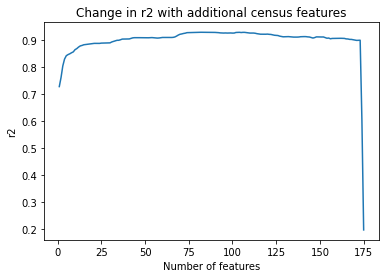

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets3_1.npy

svr_feat_subsets3_1 = np.load('../data/feat_selection/svr_feat_subsets3_1.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets3_1)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 274470.52836360154 
r2: 0.15723286375526135 
MAE: 410.0097178572624 
avg: 241.36666666666662


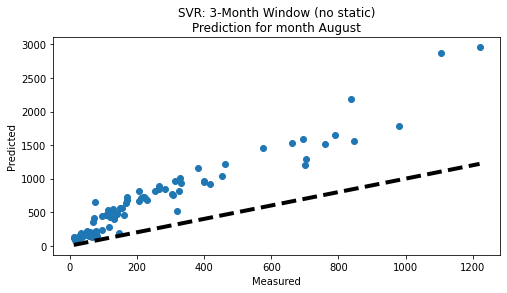

               region    Predicted  Actual  Error     % Error
16           Downtown  2871.109084    1104   1767  160.064229
19   East Los Angeles  2958.579795    1219   1739  142.705479
9       Boyle Heights  2191.629796     836   1355  162.156674
69             Sylmar  1597.273982     695    902  129.823595
33    Huntington Park  1461.766090     573    888  155.107520
..                ...          ...     ...    ...         ...
52  Pacific Palisades    87.171593      14     73  522.654239
6       Beverly Crest    87.172315      20     67  335.861576
23     Elysian Valley   131.358034      66     65   99.027325
0     Adams-Normandie   144.311090      81     63   78.161840
62       Shadow Hills    73.496185      20     53  267.480927

[89 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


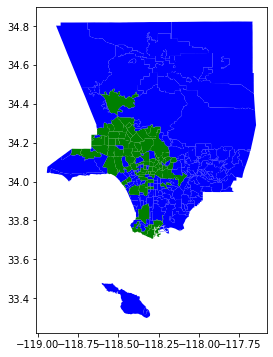

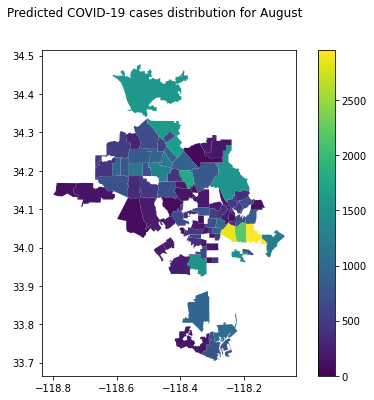

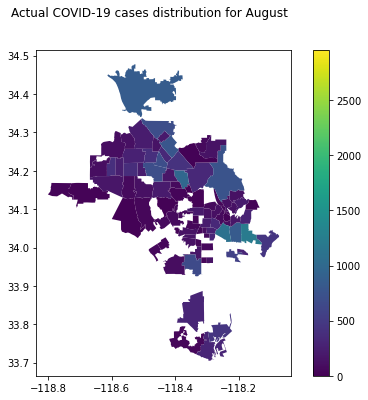

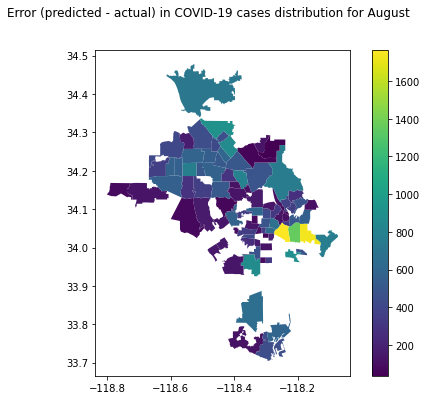

In [ ]:
train_model_single(nc3m_X_train_arr[0], nc3m_X_test_arr[0], nc3m_y_train_arr[0], nc3m_y_test_arr[0], svr_model, "SVR: 3-Month Window (no static)", 8, nc3m_pty_arr[0], used_regions)


MSE: 7786.525904816988 
r2: 0.8701004540006343 
MAE: 49.947813950354245 
avg: 241.36666666666662


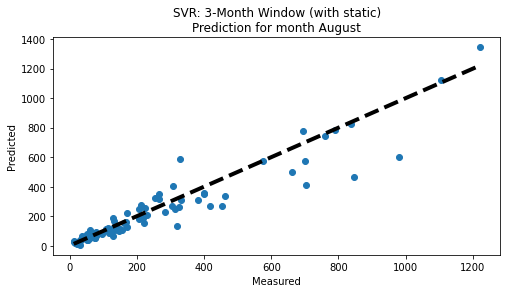

             region   Predicted  Actual  Error     % Error
85         Westlake  586.942678     329    257   78.402030
80   Vermont Square  109.080325      60     49   81.800542
45     Mid-Wilshire   78.915345      49     29   61.051725
1      Agoura Hills   63.661092      37     26   72.057006
22     Elysian Park   29.745739      12     17  147.881162
71      Toluca Lake   24.315546      11     13  121.050414
6     Beverly Crest    9.746977      20    -10   51.265113
12        Calabasas    5.057876      29    -23   82.559049
74  University Park  136.543071     319   -182   57.196529


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


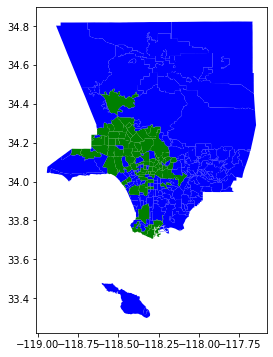

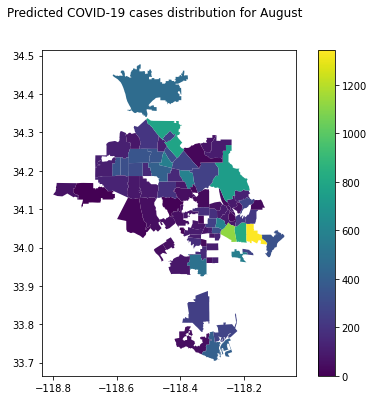

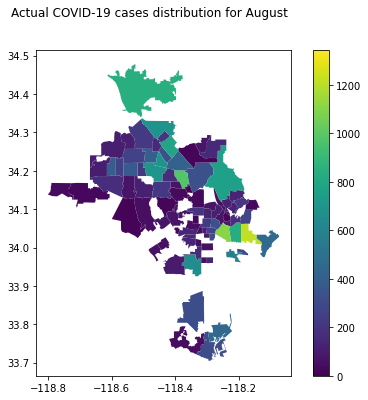

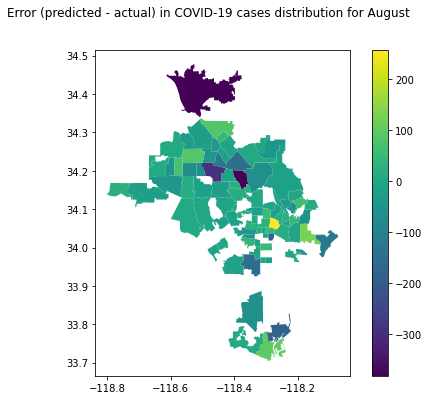

In [ ]:
train_model_single(wc3m_X_train_arr[0], wc3m_X_test_arr[0], wc3m_y_train_arr[0], wc3m_y_test_arr[0], svr_model, "SVR: 3-Month Window (with static)", 8, wc3m_pty_arr[0], used_regions)


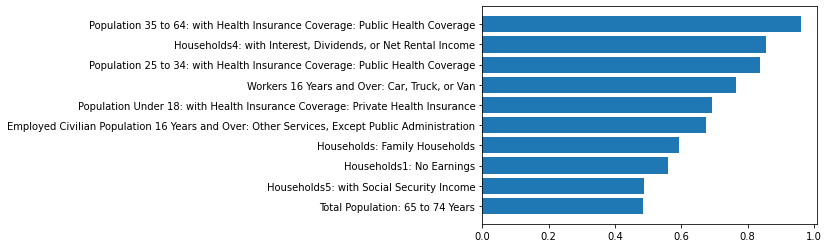

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 2

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# svr_feat_subsets3_2 = f_selection(svr_model,wc3m_X_train_arr[1].shape[1],wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets3_2.npy', svr_feat_subsets3_2, allow_pickle=True)

['cases' 'County total cases' 'Area Total: Area (Land)'
 'Total Population: 65 to 74 Years' 'Total Population: 85 Years and Over'
 'Households: Family Households: Married-Couple Family'
 'Households: Nonfamily Households: Male Householder'
 'Employed Civilian Population 16 Years and Over1: Unpaid Family Workers'
 'Households6: No Supplemental Security Income (Ssi)'
 'Households8: with Retirement Income'
 'Households9: No Other Types of Income'
 'Population for Whom Poverty Status Is Determined: 2.00 and Over'
 'Population for Whom Poverty Status Is Determined1: 2.00 and Over (Doing Ok)'
 'White Alone Population for Whom Poverty Status Is  Determined: Income At or Above Poverty Level'
 'Black or African American Alone Population for  Whom&nbsp; Poverty Status Is Determined: Income At or Above Poverty Level'
 'Asian Alone Population for Whom Poverty Status Is  Determined: Income Below Poverty Level'
 'Native Hawaiian and Other Pacific Islander Alone &nbsp; Population for Whom Poverty Sta

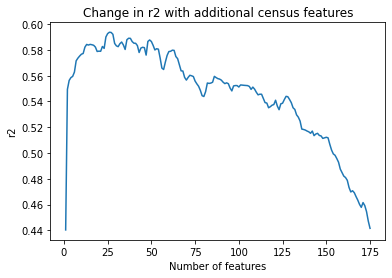

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets3_2.npy

svr_feat_subsets3_2 = np.load('../data/feat_selection/svr_feat_subsets3_2.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets3_2)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 21723.585962411933 
r2: 0.6328603217461088 
MAE: 99.15724433873302 
avg: 141.15555555555557


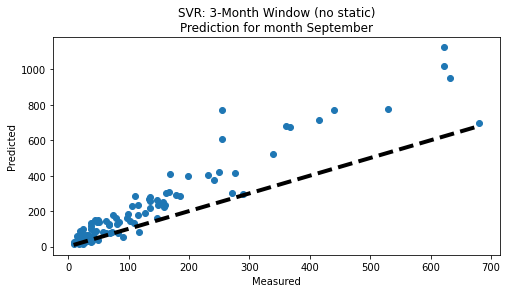

              region    Predicted  Actual  Error     % Error
9      Boyle Heights   771.356751     255    516  202.492843
19  East Los Angeles  1125.541998     621    504   81.246699
16          Downtown  1020.560909     622    398   64.077317
35         Inglewood   605.829597     255    350  137.580234
53           Pacoima   768.812720     439    329   75.128182
..               ...          ...     ...    ...         ...
45      Mid-Wilshire    52.134598      23     29  126.672164
42         Mar Vista    57.460949      32     25   79.565464
1       Agoura Hills    38.176608      14     24  172.690055
66       Studio City    43.935628      23     20   91.024470
62      Shadow Hills    22.866499       9     13  154.072211

[61 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


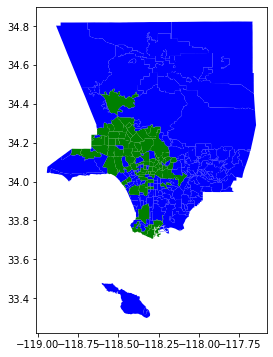

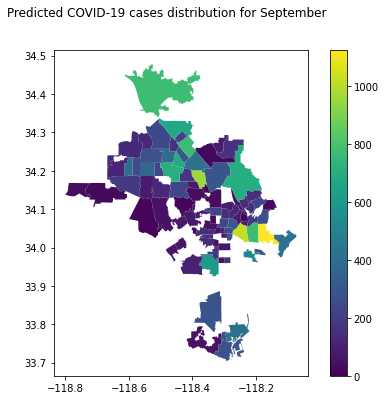

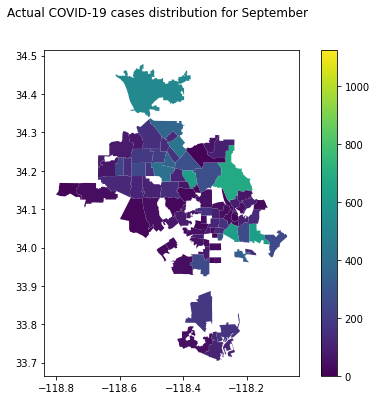

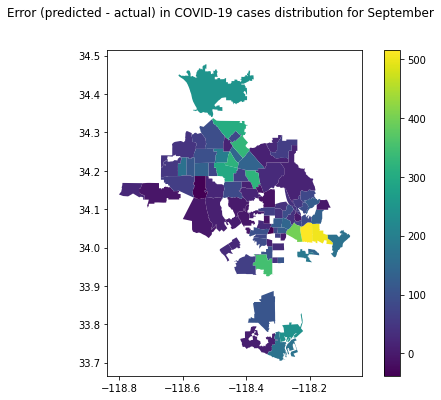

In [ ]:
train_model_single(nc3m_X_train_arr[1], nc3m_X_test_arr[1], nc3m_y_train_arr[1], nc3m_y_test_arr[1], svr_model, "SVR: 3-Month Window (no static)", 9, nc3m_pty_arr[1], used_regions)


MSE: 19620.34901356287 
r2: 0.644971794719623 
MAE: 95.06168680067054 
avg: 141.15555555555557


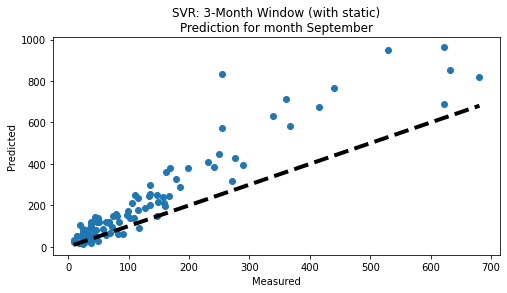

                    region   Predicted  Actual  Error     % Error
9            Boyle Heights  834.693591     255    579  227.330820
61           Santa Clarita  949.529274     528    421   79.835090
54           Panorama City  714.374445     360    354   98.437346
19        East Los Angeles  963.268738     621    342   55.115739
53                 Pacoima  765.109396     439    326   74.284600
35               Inglewood  575.460846     255    320  125.670920
33         Huntington Park  630.829005     339    291   86.085252
77                Van Nuys  676.063425     415    261   62.906849
69                  Sylmar  581.157655     368    213   57.923276
87              Wilmington  378.482924     169    209  123.954393
47              Montebello  448.139298     250    198   79.255719
85                Westlake  358.689179     162    196  121.413073
49             North Hills  382.438198     199    183   92.179999
13             Canoga Park  408.440892     232    176   76.052109
43        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


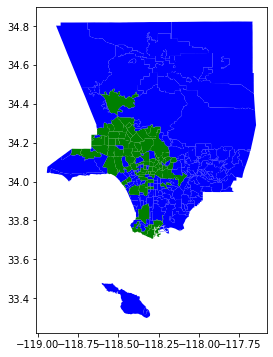

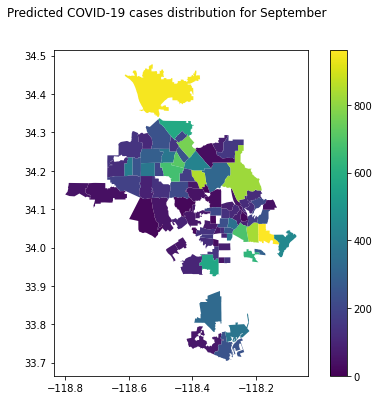

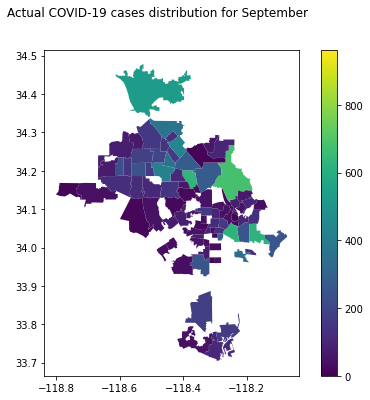

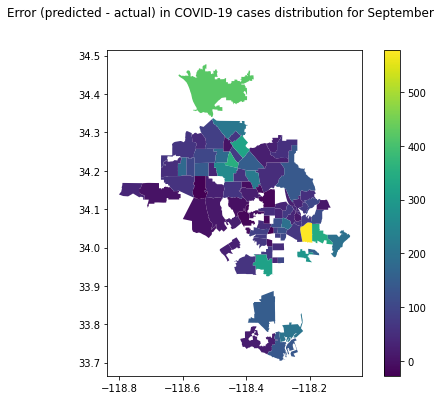

In [ ]:
train_model_single(wc3m_X_train_arr[1], wc3m_X_test_arr[1], wc3m_y_train_arr[1], wc3m_y_test_arr[1], svr_model, "SVR: 3-Month Window (with static)", 9, wc3m_pty_arr[1], used_regions)


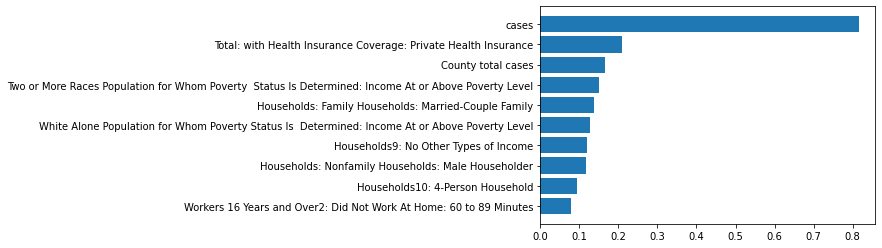

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

### Feature Selection 3

In [ ]:
month_data_ns, used_regions = build_month_data(False, True)
month_data, used_regions = build_month_data(False, True, True)

Pasadena
90
Pasadena
90


In [ ]:
# wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data, 3)
# svr_feat_subsets3_3 = f_selection(svr_model,wc3m_X_train_arr[2].shape[1],wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2])

In [ ]:
# np.save('../data/feat_selection/svr_feat_subsets3_3.npy', svr_feat_subsets3_3, allow_pickle=True)

['cases' 'Total jobs' 'Area Total: Area (Land)'
 'Total Population: Under 5 Years' 'Total Population: 5 to 9 Years'
 'Total Population: 15 to 17 Years'
 'Households: Family Households: Other Family'
 'Households: Family Households: Other Family: Male Householder, No Wife Present'
 'Households: Family Households: Other Family: Female Householder, No Husband Present'
 'Population 16 Years and Over: in Labor Force'
 'Population 16 Years and Over: in Labor Force: Civilian'
 'Population 16 Years and Over: in Labor Force: Civilian: Employed'
 'In Labor Force 16 Years and Over: Civilian'
 'Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining'
 'Employed Civilian Population 16 Years and Over: Construction'
 'Employed Civilian Population 16 Years and Over: Manufacturing'
 'Employed Civilian Population 16 Years and Over: Retail Trade'
 'Employed Civilian Population 16 Years and Over: Information'
 'Employed Civilian Population 16 Years and Over: 

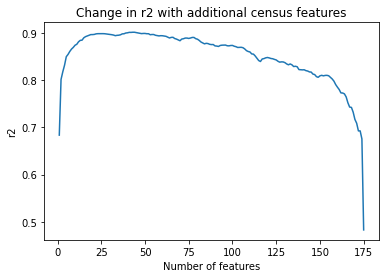

In [ ]:
!wget --directory-prefix=../data/feat_selection -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/feat_selection/svr_feat_subsets3_3.npy
svr_feat_subsets3_3 = np.load('../data/feat_selection/svr_feat_subsets3_3.npy', allow_pickle=True)[()]
month_data_ws, svr_feat_names = get_fs_data(month_data, svr_feat_subsets3_3)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

MSE: 40067.6354721398 
r2: 0.5939843375381932 
MAE: 143.2444072083051 
avg: 193.5888888888889


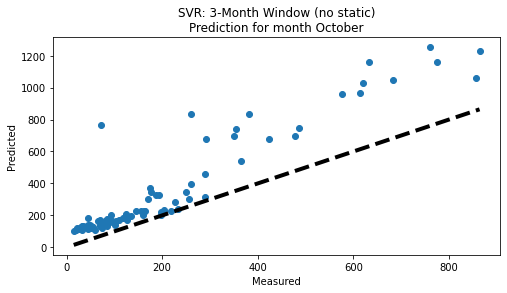

             region    Predicted  Actual  Error     % Error
74  University Park   768.568060      72    696  967.455638
33  Huntington Park   837.507813     260    577  222.118390
16         Downtown  1162.702605     633    529   83.681296
50  North Hollywood  1252.747168     761    491   64.618550
68       Sun Valley   834.790449     381    453  119.105105
..              ...          ...     ...    ...         ...
82      Westchester   130.657600      70     60   86.653714
84   West Hollywood   161.023269     102     59   57.865950
1      Agoura Hills   109.294874      59     50   85.245549
64      Silver Lake   133.947853      85     48   57.585710
15        Chinatown   119.916576      74     45   62.049427

[70 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


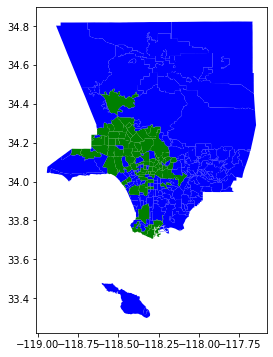

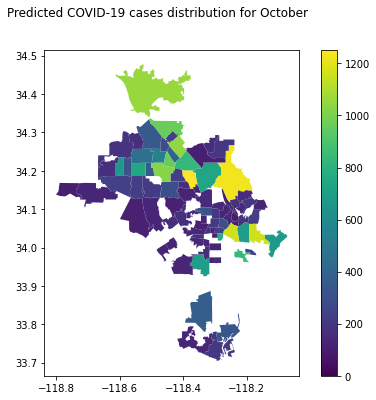

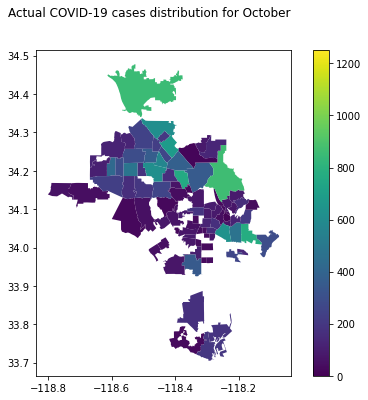

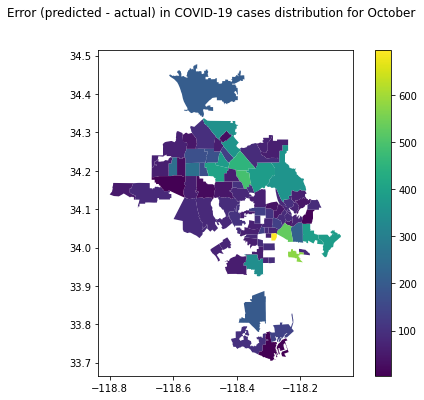

In [ ]:
train_model_single(nc3m_X_train_arr[2], nc3m_X_test_arr[2], nc3m_y_train_arr[2], nc3m_y_test_arr[2], svr_model, "SVR: 3-Month Window (no static)", 10, nc3m_pty_arr[2], used_regions)


MSE: 5046.548641724179 
r2: 0.8007972093317688 
MAE: 44.80511153296771 
avg: 193.5888888888889


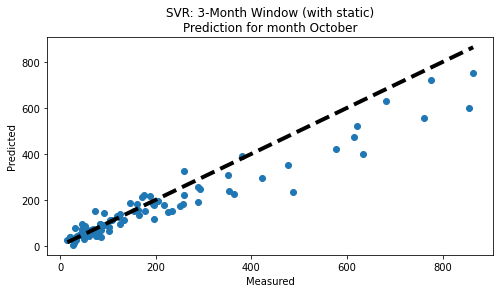

               region   Predicted  Actual  Error     % Error
74    University Park  150.223603      72     78  108.643893
18     East Hollywood  141.072619      91     50   55.024856
79     Vermont Knolls   93.597288      44     49  112.721108
80     Vermont Square   76.110115      30     46  153.700382
10          Brentwood   86.263195      50     36   72.526389
20          Echo Park   80.949369      48     32   68.644518
29    Harvard Heights   70.637969      44     26   60.540838
3   Arlington Heights   66.831749      44     22   51.890339
62       Shadow Hills   37.791916      19     18   98.904820
71        Toluca Lake   38.735167      20     18   93.675835
22       Elysian Park   23.568423      14      9   68.345880
52  Pacific Palisades    9.693386      27    -17   64.098571
6       Beverly Crest    3.498125      25    -21   86.007501
64        Silver Lake   39.872111      85    -45   53.091634
58             Reseda  233.351502     486   -252   51.985288


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


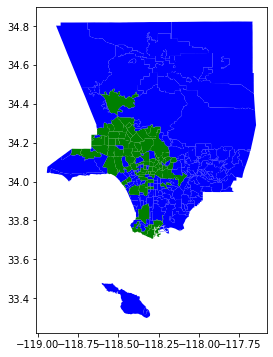

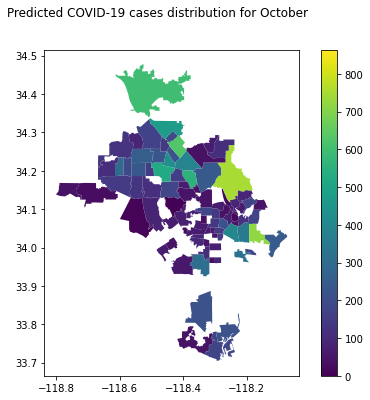

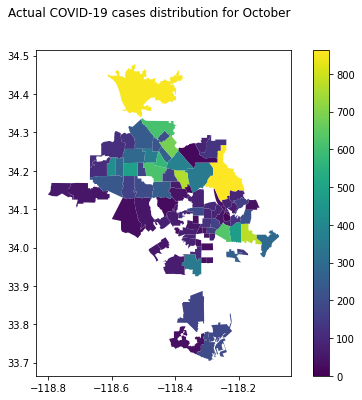

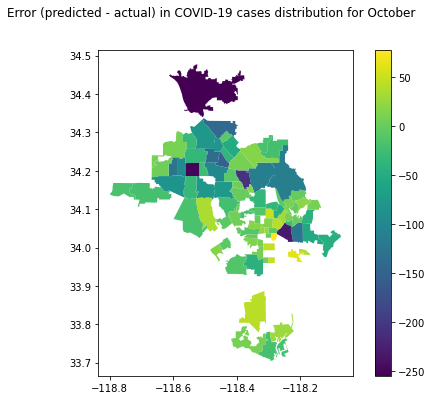

In [ ]:
train_model_single(wc3m_X_train_arr[2], wc3m_X_test_arr[2], wc3m_y_train_arr[2], wc3m_y_test_arr[2], svr_model, "SVR: 3-Month Window (with static)", 10, wc3m_pty_arr[2], used_regions)

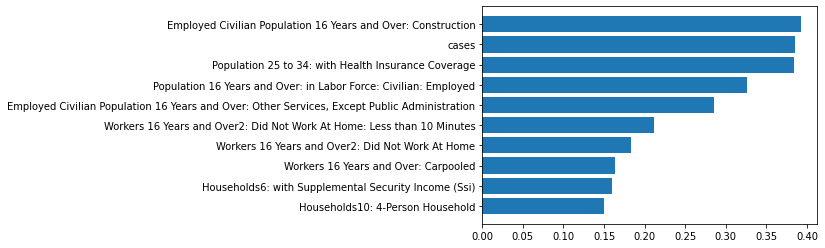

In [ ]:
feat_im_df = f_importances(svr_model, svr_feat_names, 'SVR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

# GBR

In [ ]:
gb_param = {
#     'n_estimators': 700,
#     'max_depth': 16,
#     'min_samples_split': 100,
#     'learning_rate': 0.01,
#     'loss': 'ls'
}
gb_model = GradientBoostingRegressor(**gb_param)

### Cases Only

195
MSE: [12544.07137254315]; avg = 12544.07137254315 
r2: [0.7499153095828812]; avg = 0.7499153095828812
MAE: [62.94000478474417]; avg = 62.94000478474417
avg: [160.03589743589743]; avg = 160.03589743589743


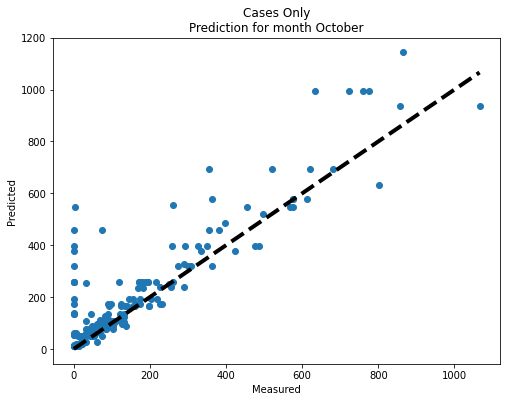

In [ ]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5, False)
train_model_no_transform(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases Only", 5)

### Add Normalization

195
MSE: [10958.86830186253]; avg = 10958.86830186253 
r2: [0.7681583353273306]; avg = 0.7681583353273306
MAE: [58.31613825557545]; avg = 58.31613825557545
avg: [160.03589743589743]; avg = 160.03589743589743


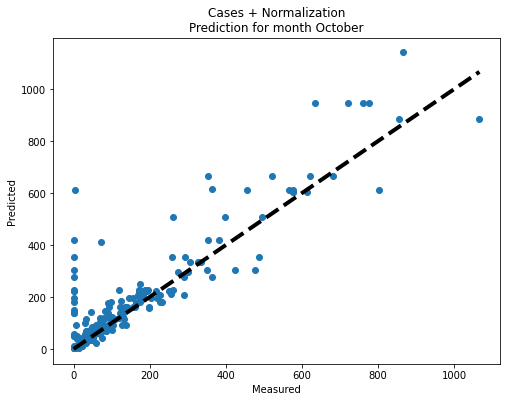

                 region   Predicted        Actual  Error
16         Baldwin Park  664.358636  3.540000e+02    310
41               Covina  418.820639  5.684342e-14    418
47             Downtown  946.496618  6.330000e+02    313
60   Florence-Firestone  610.014337  4.000000e+00    606
126            Pasadena  302.415894  5.684342e-14    302
158      South Whittier  355.226928  5.684342e-14    355
169     University Park  412.707309  7.300000e+01    339
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


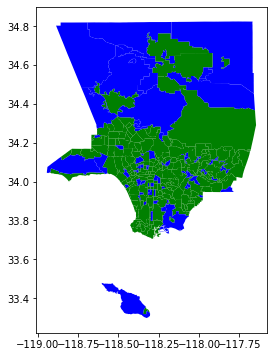

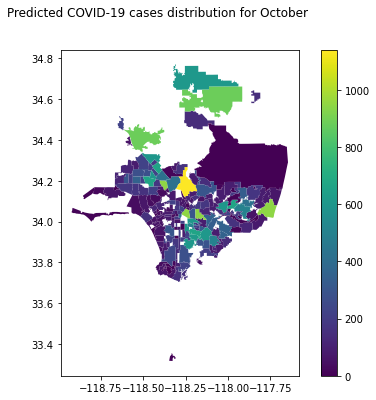

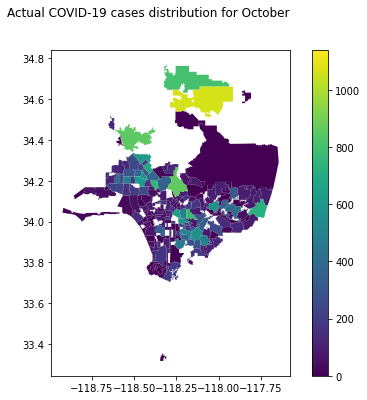

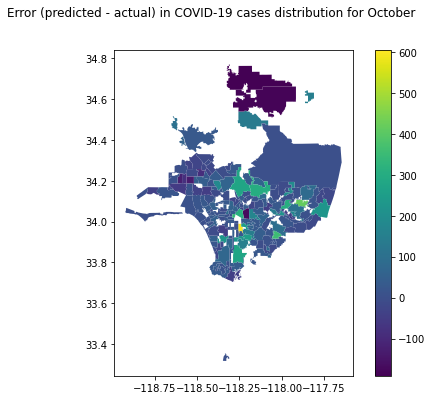

In [ ]:
month_data, used_regions = build_month_data()
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization", nc5m_pty_arr, 5, used_regions)

### Add Migration

91
MSE: [6557.842389200729]; avg = 6557.842389200729 
r2: [0.8077929380042463]; avg = 0.8077929380042463
MAE: [49.13901273866214]; avg = 49.13901273866214
avg: [191.46153846153845]; avg = 191.46153846153845


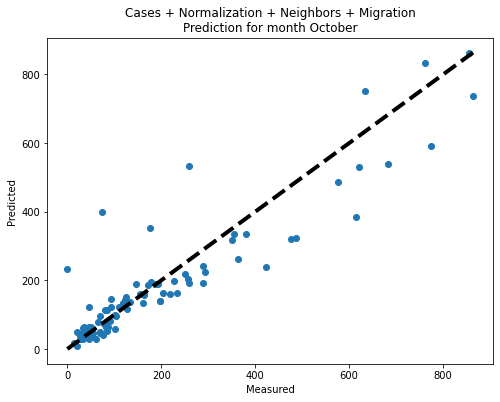

             region   Predicted  Actual  Error
75  University Park  400.175474    73.0    327
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


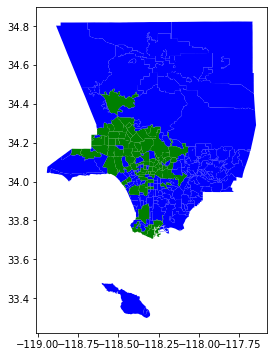

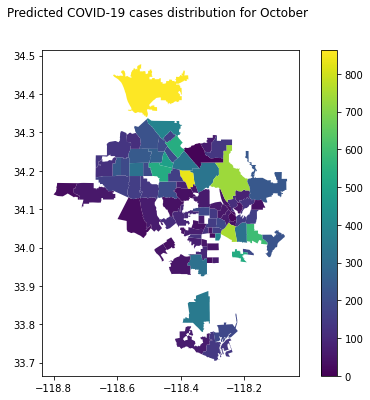

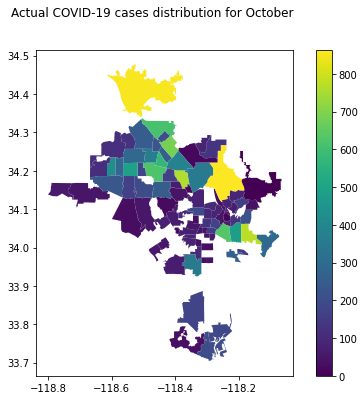

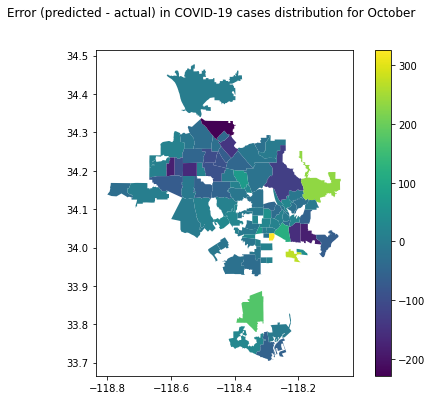

In [ ]:
month_data, used_regions = build_month_data(False, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration", nc5m_pty_arr, 5, used_regions)

### Add Census

91
MSE: [8861.324306204016]; avg = 8861.324306204016 
r2: [0.791170464796997]; avg = 0.791170464796997
MAE: [53.272993388189846]; avg = 53.272993388189846
avg: [191.46153846153845]; avg = 191.46153846153845


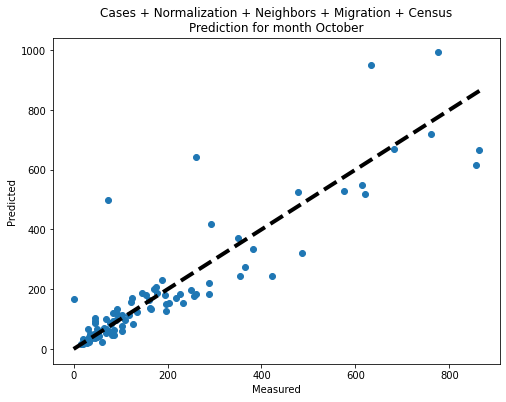

             region   Predicted  Actual  Error
16         Downtown  949.672688   633.0    316
33  Huntington Park  642.580159   260.0    382
75  University Park  499.956459    73.0    426
Empty DataFrame
Columns: [region, Predicted, Actual, Error]
Index: []


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


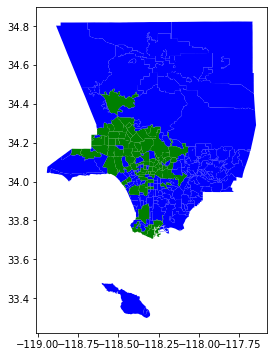

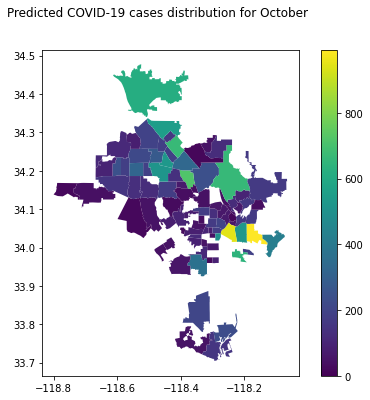

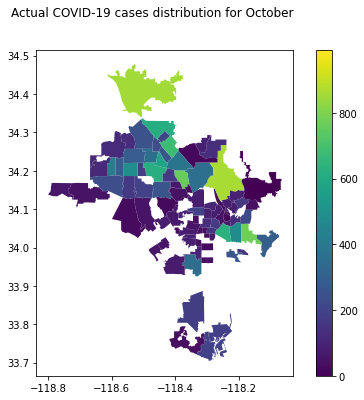

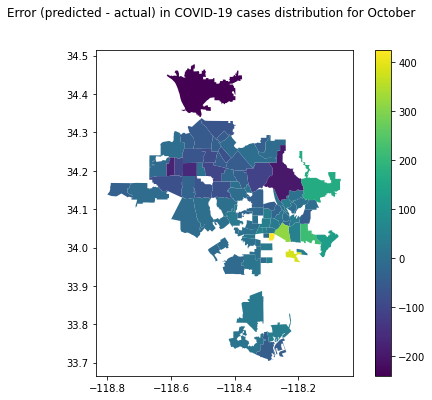

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration + Census", nc5m_pty_arr, 5, used_regions)

### Feature Selection

In [ ]:
# month_data = build_month_data(False, True, True)
# nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data, 5)
# lin_feat_subsets = f_selection(lin_model,nc5m_X_train_arr[0].shape[1],nc5m_X_train_arr[0],nc5m_y_train_arr[0])

In [ ]:
month_data, used_regions = build_month_data(False, True, True)
month_data_ws, lin_feat_names = get_fs_data(month_data, lin_feat_subsets)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ws, 5)
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection", nc5m_pty_arr, 5, used_regions)

91


NameError: ignored

In [ ]:
gb_param_grid = {
   'n_estimators': [100, 500, 1000],
    'max_depth': [2, 6, 10, 16],
    'min_samples_split': [2, 10, 50],
}

gb_model = GradientBoostingRegressor()
gb_search = GridSearchCV(gb_model, gb_param_grid)

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_search, "Cases + Normalization + Neighbors + Migration + Census + Feat Selection + Local Search", nc5m_pty_arr, 5)

In [ ]:
gb_search.best_estimator_

### Feature Importance

In [ ]:
feat_im_df = f_importances(gb_model, lin_feat_names, 'GBR')

In [ ]:
feat_im_df.head(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
feat_im_df.tail(10).style.set_properties(subset=['Feature Name'], **{'width': '300px'})

In [ ]:
month_data_ns = build_month_data(False, True)

In [ ]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_ns, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_ws, 5)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_ns, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_ws, 4)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_ns, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_ws, 3)

In [ ]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_ns, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_ws, 2)

In [ ]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_ns, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_ws, 1)

In [ ]:
gb_param = {
    'max_depth': 2,
    'min_samples_split': 50,
}
gb_model = GradientBoostingRegressor(**gb_param)

## 5 month window

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, gb_model, "GBR: 5-Month Window (no static)", nc5m_pty_arr, 5, used_regions)

In [ ]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, gb_model, "GBR: 5-Month Window (with static)", wc5m_pty_arr, 5, used_regions)

## 4 month window

In [ ]:
train_model(nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, gb_model, "GBR: 4-Month Window (no static)", nc4m_pty_arr, 4, used_regions)

In [ ]:
train_model(wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, gb_model, "GBR: 4-Month Window (with static)", wc4m_pty_arr, 4, used_regions)

## 3 month window

In [ ]:
train_model(nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, gb_model, "GBR: 3-Month Window (no static)", nc3m_pty_arr, 3, used_regions)

In [ ]:
train_model(wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, gb_model, "GBR: 3-Month Window (with static)", wc3m_pty_arr, 3, used_regions)

## 2 month window

In [ ]:
train_model(nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, gb_model, "GBR: 2-Month Window (no static)", nc2m_pty_arr, 2, used_regions)

In [ ]:
train_model(wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, gb_model, "GBR: 2-Month Window (with static)", wc2m_pty_arr, 2, used_regions)

## 1 month window

In [ ]:
train_model(nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, gb_model, "GBR: 1-Month Window (no static)", nc1m_pty_arr, 1, used_regions)

In [ ]:
train_model(wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, svr_model, "GBR: 1-Month Window (with static)", wc1m_pty_arr, 1, used_regions)

# Graph change in r^2

In [ ]:
y1=[0.794, 0.724, 0.434]
y2=[0.816, 0.7365, 0.737]
# plt.plot(x, y1, 'ro-', x, y2, 'bo-')
plt.plot(y1, 'bo-', label="No Static", )
plt.plot(y2, 'ro-', label="With Static")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks([0,1,2],[5,4,3])
plt.ylabel('r^2')
plt.xlabel('n-month window')
plt.title('SVR: change in r^2 across different time windows')
plt.figure(figsize=(7,7))
plt.show()

In [ ]:
y1=[0.792, 0.735, 0.419]
y2=[0.834, 0.708, 0.744]
# plt.plot(x, y1, 'ro-', x, y2, 'bo-')
plt.plot(y1, 'bo-', label="No Static", )
plt.plot(y2, 'ro-', label="With Static")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks([0,1,2],[5,4,3])
plt.ylabel('r^2')
plt.xlabel('n-month window')
plt.title('LinReg: change in r^2 across different time windows')
plt.figure(figsize=(7,7))
plt.show()

# XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

# Feature Selection

## The following takes a long time to run!!! Just use the cell below this section

In [ ]:
month_data_with_census = build_month_data_with_census(census_data)
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)
xg_feat_subsets = f_selection(xg_model,wc5m_X_train_arr[0].shape[1],wc5m_X_train_arr[0],wc5m_y_train_arr[0])

In [ ]:
print(xg_feat_subsets)
np.save('../data/xg_feat_subsets.npy',xg_feat_subsets, allow_pickle=True)

## Run this section instead!!

In [ ]:
month_data_with_census = build_month_data_with_census(census_data)
svr_feat_subsets = np.load('../data/svr_feat_subsets.npy', allow_pickle=True)[()]
svr_feat_subsets

In [ ]:
def get_optimal_index(feat_subsets):
    feature_counts = []
    r2s = []
    optimal_feat = None
    optimal_r2 = None
    for key, value in feat_subsets.items():
        if key == 1:
            optimal_r2 = value['avg_score']
            optimal_feat = value
        elif (value['avg_score'] > optimal_r2):
            optimal_feat = value
            optimal_r2 = value['avg_score']
        feature_counts.append(key)
        r2s.append(value['avg_score'])
    optimal_index = np.array(list(set(optimal_feat['feature_idx']) | {0, 1, 2, 3, 4})) ## Add dynamic features to the list of optimal features
    print(np.array(feature_names)[optimal_feat_index])
    
    plt.plot(feature_counts, r2s)
    plt.xlabel('Number of features')
    plt.ylabel('r2')
    plt.title('Change in r2 with additional census features')
    plt.show()
    return optimal_index

In [ ]:
svr_optimal_index = get_optimal_index(svr_feat_subsets)
svr_optimal_index

## Generate train-test set

In [ ]:
# Select only the top features
temp = np.append(svr_optimal_index+1, month_data_with_census.shape[1]-1)
month_data_with_census = month_data_with_census[:, np.insert(temp, 0, 0, axis=0)] # Insert month and target columns
month_data_with_census.shape

In [ ]:
nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, nc5m_ptX_arr, nc5m_pty_arr = n_month_window_split(month_data_no_census, 5)
wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, wc5m_ptX_arr, wc5m_pty_arr = n_month_window_split(month_data_with_census, 5)

In [ ]:
nc4m_X_train_arr, nc4m_X_test_arr, nc4m_y_train_arr, nc4m_y_test_arr, nc4m_ptX_arr, nc4m_pty_arr = n_month_window_split(month_data_no_census, 4)
wc4m_X_train_arr, wc4m_X_test_arr, wc4m_y_train_arr, wc4m_y_test_arr, wc4m_ptX_arr, wc4m_pty_arr = n_month_window_split(month_data_with_census, 4)

In [ ]:
nc3m_X_train_arr, nc3m_X_test_arr, nc3m_y_train_arr, nc3m_y_test_arr, nc3m_ptX_arr, nc3m_pty_arr = n_month_window_split(month_data_no_census, 3)
wc3m_X_train_arr, wc3m_X_test_arr, wc3m_y_train_arr, wc3m_y_test_arr, wc3m_ptX_arr, wc3m_pty_arr = n_month_window_split(month_data_with_census, 3)

In [ ]:
nc2m_X_train_arr, nc2m_X_test_arr, nc2m_y_train_arr, nc2m_y_test_arr, nc2m_ptX_arr, nc2m_pty_arr = n_month_window_split(month_data_no_census, 2)
wc2m_X_train_arr, wc2m_X_test_arr, wc2m_y_train_arr, wc2m_y_test_arr, wc2m_ptX_arr, wc2m_pty_arr = n_month_window_split(month_data_with_census, 2)

In [ ]:
nc1m_X_train_arr, nc1m_X_test_arr, nc1m_y_train_arr, nc1m_y_test_arr, nc1m_ptX_arr, nc1m_pty_arr = n_month_window_split(month_data_no_census, 1)
wc1m_X_train_arr, wc1m_X_test_arr, wc1m_y_train_arr, wc1m_y_test_arr, wc1m_ptX_arr, wc1m_pty_arr = n_month_window_split(month_data_with_census, 1)

In [ ]:
gb_param = {
    'n_estimators': 900,
    'max_depth': 2,
    'min_samples_split': 100,
    'learning_rate': 0.01,
    'loss': 'ls'
}
xg_model = XGBRegressor(**gb_param)

In [ ]:
train_model(nc5m_X_train_arr, nc5m_X_test_arr, nc5m_y_train_arr, nc5m_y_test_arr, xg_model, "XGB: 5-Month Window (no static)", 5)

In [ ]:
train_model(wc5m_X_train_arr, wc5m_X_test_arr, wc5m_y_train_arr, wc5m_y_test_arr, xg_model, "XGB: 5-Month Window (with static)", 5)

# Scratch Work

In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
        t1 = scale(power_transform(feat.reshape(-1,1)))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


In [ ]:
pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
for i in range(1, month_data_with_census.shape[1]-1):
    s = skew(month_data_with_census[:,i])
    if abs(s) > 1:
        print("skewness: " + str(s))
        plt.hist(month_data_with_census[:,i])
        plt.title(feature_names[i-1])
        plt.show()
        print('###### Transform')
#         feat = (month_data_with_census[:,i].max()+1)-month_data_with_census[:,i]
        feat = (1+month_data_with_census[:,i])
#         t1 = scale(power_transform(feat.reshape(-1,1)))
        t1 = pipe.fit_transform(feat.reshape(-1,1))
        print('yeo-johnson: ' + str(skew(t1)[0]))
        t2 = scale(np.log(feat))
        print('log: ' + str(skew(t2)))
        plt.hist(t2, alpha=0.5)
        plt.show()
        plt.hist(t1, color='green')
        plt.title(feature_names[i-1])
        green_patch = mpatches.Patch(color='green', label='Yeo-Johnson')
        purple_patch = mpatches.Patch(color='blue', label='Log')
        plt.legend(handles=[green_patch, purple_patch])
        plt.show()
        


In [ ]:
for i in range(wc4m_X_train_arr[0].shape[1]):
    s = skew(wc4m_X_train_arr[0][:,i])
    print("skewness: " + str(s))
    plt.hist(wc4m_X_train_arr[0][:,i])
    plt.title(feature_names[i-1])
    plt.show()
        


In [ ]:
for i in range(1, month_data_with_census.shape[1]-1):
    plt.hist(month_data_with_census[:,i])
    plt.title(feature_names[i-1])
    plt.show()